### Libraries

In [24]:
import os
import sys
import re
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, mapping, LineString, MultiLineString, shape
from sklearn.linear_model import LinearRegression
import rasterio
from rasterio.mask import mask as rio_mask
from rasterio.enums import Resampling
from rasterio.features import shapes
from rasterio.warp import transform
import numpy as np
from pathlib import Path
from pyproj import Transformer
import glob
from shapely.ops import unary_union
from concurrent.futures import ThreadPoolExecutor, as_completed
import multiprocessing
import warnings
import matplotlib.pyplot as plt
from sklearn.linear_model import HuberRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import random
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import math
import csv
from concurrent.futures import ThreadPoolExecutor, as_completed
from config_paths import DATA, OUTPUT, INTERMEDIATE
from ast import literal_eval
import fnmatch, yaml 
from matplotlib.ticker import PercentFormatter

This code uses bathymetry models, together with SWOT data and and cross-section shapefiles, to create raster maks of WSE. Intercepting cross-sections with the masks river widths are estimate.

#### 0. PATHS

In [7]:
# Regressions
regress_path = pd.read_csv(OUTPUT/"Global_22_07_25/B774_huber_reg.csv")#/dark_fr_030/8_bits/S3_15Obs_100W/jul_3_25/Po_River_huber_reg_3.csv")) #No_Norm/dark_fr_030/8_bits/S3_15Obs_100W/jun_6_25/
                                        #"Po_River_huber_reg.csv"))
poly_path = gpd.read_file(INTERMEDIATE/"Store/Binary_Masks/Po/Shps/Po.shp")
tif_path = DATA/"External/Bathymetries/namerica/Sacramento_River/Sacramento_EGM08.tif"
base_folder = INTERMEDIATE/"Store/Binary_Masks/Po/"
#swot_simple = INTERMEDIATE/"Store/Validation/csv/Atrato/Atrato_reg_bottom_error_simple.csv"

#### 1. Subsetting only the nodes lying inside the raster 

In [ ]:
with rasterio.open(tif_path) as src:
    nod = src.nodata
    # pull lon/lat from your DataFrame
    xs = regress_path["lon"].values
    ys = regress_path["lat"].values

    # ─── NEW: reproject point coords into the raster’s CRS ───
    xs, ys = transform(
        "EPSG:4326",    # source CRS of your lon/lat
        src.crs,        # target CRS (raster.crs)
        xs.tolist(),
        ys.tolist(),
    )
    xs = np.array(xs)
    ys = np.array(ys)

    # Check raster bounds (now in raster CRS)
    left, bottom, right, top = src.bounds
    inside_bounds = (xs >= left) & (xs <= right) & (ys >= bottom) & (ys <= top)
    
    # Preallocate array for sampled values (nan for out-of-bounds)
    sampled = np.full(xs.shape, np.nan)
    xs_in = xs[inside_bounds]
    ys_in = ys[inside_bounds]
    idxs_in = np.where(inside_bounds)[0]
    if len(xs_in) > 0:
        vals = list(src.sample(zip(xs_in, ys_in)))
        vals = np.array([v[0] for v in vals])
        sampled[idxs_in] = vals

    # Mask: inside bounds AND not nodata AND not nan
    mask = inside_bounds & (~np.isnan(sampled)) & ((nod is None) | (sampled != nod))

# subset and export
regress_path_inside = regress_path[mask]
print(f"{regress_path_inside.shape[0]} nodes inside raster, {regress_path.shape[0]} total nodes")

regress_path_inside.to_csv(
    os.path.join(INTERMEDIATE, "Store/Validation/csv/Sacramento/Sacramento_validate_nodes.csv"
    ),
    index=False
)

#### 2. Extract from bathymetry the bottom of the river channel

In [ ]:
with rasterio.open(tif_path) as src:
    # 1) show me the raster’s CRS
    print("Raster CRS is:", src.crs)

    # 2) if your poly_path is still EPSG:4326, move it into the raster’s CRS
    if poly_path.crs != src.crs:
        poly_path = poly_path.to_crs(src.crs)

    results = []
    for _, row in poly_path.iterrows():
        node = row["node_id"]
        geom = [mapping(row.geometry)]
        out_image, _ = rio_mask(
            src,
            geom,
            crop=True,         # keeps memory use tiny
            all_touched=True,
            nodata=src.nodata,
            filled=False
        )
        arr = out_image[0].astype("float32")
        arr = np.ma.masked_equal(arr, src.nodata)
        arr = np.ma.masked_where(np.isnan(arr), arr)
        min_val = arr.min() if arr.count() > 0 else np.nan
        results.append({"node_id": node, "min_value": float(min_val)})

lprb = pd.DataFrame(results)
lprb.to_csv(
    os.path.join(
        INTERMEDIATE,
        "Store/Validation/csv/Sacramento/Sacramento_channel_min_values.csv"
    ),
    index=False
)
    

In [ ]:
lprb = pd.read_csv(INTERMEDIATE/"Store/Validation/csv/Garonne/Garonne_reg_bottom_error_simple.csv")

Merge the two csv files, the one with the regression values and the one with the minimum values in the river bed, and then  
estimate the difference and errors between the intercepts and the real bathymetry

In [ ]:
# Ensure node_id is string in both DataFrames for a valid merge
regress_path["node_id"] = regress_path["node_id"].astype(str)
lprb["node_id"] = lprb["node_id"].astype(str)

merged = regress_path.merge(
    lprb[["node_id", "min_value"]],
    on="node_id",
    how="inner"
)

intercept = np.where(
    merged["intercept2"].isnull(),
    merged["intercept1"],
    merged["intercept2"]
)

merged["error"] = intercept - merged["min_value"]
merged["abs_error"] = merged["error"].abs()
merged["rel_error_%"] = merged["error"] / merged["min_value"] * 100

merged.to_csv(os.path.join(INTERMEDIATE, "Store/Validation/csv/Sacramento/Sacramento_reg_bottom_error.csv"), index=False)

In [2]:
master_csv_path = INTERMEDIATE/"Store/Validation/csv/Po/Po_reg_bottom_error_simple.csv"

Create folders for each node_id

In [ ]:
# 2) Base directory where you want to create the folders
#    For example: "/path/to/output_folders"


# 3) Read the master CSV into a DataFrame
master_df = pd.read_csv(master_csv_path)

# 4) Extract unique node_id values (as strings)
unique_nodes = master_df["node_id"].astype(str).unique()

# 5) Write the list of node_id codes to a CSV (no header, one per line)
list_csv_path = os.path.join(base_folder, "node_ids_list.csv")
pd.Series(unique_nodes).to_csv(list_csv_path, index=False, header=False)

# 6) Loop over each unique node_id and create a folder if it doesn't already exist
for node_id in unique_nodes:
    node_folder = os.path.join(base_folder, node_id)
    # exist_ok=True means “do nothing if the folder already exists”
    os.makedirs(node_folder, exist_ok=True)
    print(f"Ensured folder exists: {node_folder}")

Create in each node_id folder, a csv file with a list of WSE extracted from the regression csv for each node_id

In [ ]:
def export_wse_csvs(
    master_csv_path: str,
    base_folder: str,
    subtract_value: float = 2.04,
    apply_subtraction: bool = False
):
    """
    For each node_id in master_df, write:
        1) raw WSEs → base_folder/node_id/node_id.csv
        2) (optionally) adjusted WSEs (WSE - subtract_value)
            → base_folder/node_id/node_id_adjusted.csv

    Args:
        master_csv_path: path to CSV with columns 'node_id' and 'wse'
        base_folder: directory that will contain subfolders named by node_id
        subtract_value: the value to subtract from each WSE when apply_subtraction=True
        apply_subtraction: if True, also create the adjusted CSV
    """
    # Check if file exists
    if not os.path.exists(master_csv_path):
        print(f"Error: File '{master_csv_path}' does not exist.")
        return

    # Read the master table
    df = pd.read_csv(master_csv_path)

    # Loop through each distinct node_id
    for node_id in df["node_id"].astype(str).unique():
        # Grab all the WSE values for this node
        wse_values = df.loc[df["node_id"].astype(str) == node_id, "wse"]

        # Ensure the node's folder exists
        node_folder = os.path.join(base_folder, node_id)
        os.makedirs(node_folder, exist_ok=True)

        # 1) Write the raw WSEs
        raw_path = os.path.join(node_folder, f"{node_id}.csv")
        wse_values.to_csv(raw_path, index=False, header=False)
        print(f"✔ Saved {len(wse_values)} raw WSEs to {raw_path}")

        # 2) If requested, write the adjusted WSEs
        if apply_subtraction:
            adjusted = wse_values - subtract_value
            adj_path = os.path.join(node_folder, f"{node_id}_adjusted.csv")
            adjusted.to_csv(adj_path, index=False, header=False)
            print(f"✔ Saved {len(adjusted)} adjusted WSEs to {adj_path}")


In [ ]:
# Just export raw WSE lists:
export_wse_csvs(master_csv_path, base_folder)

# Export raw WSE lists *and* create adjusted CSVs (subtract 2.04):
#export_wse_csvs(master_csv_path, base_folder, apply_subtraction=True)

# Export with a different subtraction value, say 1.5:
#export_wse_csvs(master_csv_path, base_folder, subtract_value=1.5, apply_subtraction=True)

#### 3. Create a mask for each WSE in each node_id

In [ ]:
limit_to    = None                     # or e.g. ["21406100080691", "21406100080702"]

# Tunable: number of worker threads for writing masks
_max_workers = min(8, os.cpu_count() or 4)

def _write_mask_single(out_path, profile, dem, valid, nodata_mask, nodata_value, t):
    """Build and write one mask TIFF for threshold t."""
    mask = np.zeros_like(dem, dtype=np.uint8)
    np.less_equal(dem, t, where=valid, out=mask, casting="unsafe")
    mask[nodata_mask] = 255
    with rasterio.open(out_path, "w", **profile) as dst:
        dst.write(mask, 1)
    return out_path

with rasterio.Env(GDAL_NUM_THREADS="ALL_CPUS", VSI_CACHE="TRUE", VSI_CACHE_SIZE=str(256*1024*1024)):
    # === STEP 1: Read the DEM ONCE ===
    with rasterio.open(tif_path) as src:
        dem = src.read(1, resampling=Resampling.nearest)
        profile = src.profile.copy()
        nodata_value = src.nodata if src.nodata is not None else -9999

    profile.update({
        "dtype": rasterio.uint8,
        "count": 1,
        "nodata": 255,
        "compress": "lzw"
    })

    nodata_mask = (dem == nodata_value)
    valid = ~nodata_mask

    # === STEP 2: Locate all node_id subfolders ===
    node_folders = [d for d in glob.glob(os.path.join(base_folder, "*")) if os.path.isdir(d)]
    if limit_to is not None:
        node_folders = [d for d in node_folders if os.path.basename(d) in limit_to]

    print(f"🔍 Found {len(node_folders)} node‐folders to process.\n")

    # === STEP 3: Process each folder ===
    for node_folder in node_folders:
        node_id = os.path.basename(node_folder)
        print(f" Processing node_id = {node_id}")

        csv_files = glob.glob(os.path.join(node_folder, "*.csv"))
        if not csv_files:
            print(f" No CSVs found inside {node_folder}. Skipping.\n")
            continue

        for csv_path in csv_files:
            try:
                df_wse = pd.read_csv(csv_path, header=None, names=["wse"], dtype=float)
            except Exception as e:
                print(f"Failed to read {csv_path}: {e}")
                continue

            wse_values = df_wse["wse"].dropna().values
            if wse_values.size == 0:
                print(f"No valid WSE values in {csv_path}. Skipping this file.")
                continue

            print(f"Found {len(wse_values)} thresholds in {os.path.basename(csv_path)}")

            masks_folder = os.path.join(node_folder, "masks")
            os.makedirs(masks_folder, exist_ok=True)

            futures = []
            with ThreadPoolExecutor(max_workers=_max_workers) as ex:
                for t in wse_values:
                    t_str = str(t).replace(".", "_").replace("-", "m")
                    out_name = f"mask_{t_str}.tif"
                    out_path = os.path.join(masks_folder, out_name)

                    if os.path.exists(out_path):
                        print(f"      • {out_name} already exists. Skipping.")
                        continue

                    futures.append(
                        ex.submit(_write_mask_single, out_path, profile, dem, valid, nodata_mask, nodata_value, t)
                    )

                for f in as_completed(futures):
                    try:
                        done_path = f.result()
                        print(f"Saved {os.path.basename(done_path)}")
                    except Exception as e:
                        print(f"      • Failed to write a mask: {e}")

        print("")  # blank line

    print("All node‐folders processed.")

#### 4. Measuring river widths

In [ ]:
warnings.filterwarnings("ignore", category=rasterio.errors.NotGeoreferencedWarning)

def ensure_mask_georeferenced(mask_path, ref_crs, ref_transform):
    with rasterio.open(mask_path, 'r+') as dst:
        needs_update = False
        if dst.crs is None:
            dst.crs = ref_crs
            needs_update = True
        if dst.transform.is_identity:
            dst.transform = ref_transform
            needs_update = True
        if needs_update:
            print(f"Updated georeferencing for: {os.path.basename(mask_path)}")

def fix_all_masks_in_base_folder(base_folder, ref_crs, ref_transform):
    for node_folder in os.listdir(base_folder):
        masks_dir = os.path.join(base_folder, node_folder, "masks")
        if os.path.isdir(masks_dir):
            for mask_path in glob.glob(os.path.join(masks_dir, "mask_*.tif")):
                ensure_mask_georeferenced(mask_path, ref_crs, ref_transform)

def extract_wse(mask_filename):
    # strip extension and split on underscores
    name = os.path.splitext(os.path.basename(mask_filename))[0]
    parts = name.split('_')   # ["mask", "50", "535"]
    if len(parts) == 3:
        return float(f"{parts[1]}.{parts[2]}")  # "50" + "." + "535" → 50.535
    return None

def possible_node_id_strings(node_id):
    candidates = set()
    candidates.add(str(node_id))
    try:
        as_float = float(node_id)
        candidates.add(str(int(as_float)))
        candidates.add(f"{as_float:.3f}")
        candidates.add(f"{as_float:.1f}")
    except Exception:
        pass
    return list(candidates)

def measure_mask_segments_by_sampling(polyline, mask_path, gdf_crs, spacing=1):
    with rasterio.open(mask_path) as src:
        raster_crs = src.crs

        # ─── REPLACED: use the mask/raster CRS (e.g. EPSG:6339) instead of Italy UTM ───
        utm_crs = raster_crs

        if gdf_crs and gdf_crs != utm_crs:
            polyline_proj = gpd.GeoSeries([polyline], crs=gdf_crs).to_crs(utm_crs).iloc[0]
        else:
            polyline_proj = polyline

        length = polyline_proj.length
        if length < spacing:
            return []

        num_points = int(length / spacing)
        distances = np.linspace(0, length, num_points)
        points = [polyline_proj.interpolate(d) for d in distances]

        coords = gpd.GeoSeries(points, crs=utm_crs).to_crs(raster_crs)
        coords = [(pt.x, pt.y) for pt in coords]

        vals = [v[0] for v in src.sample(coords)]
        vals = [int(round(v)) if v in [0, 1] else 0 for v in vals]

        segments = []
        in_segment = False
        start_dist = None

        for i in range(1, len(vals)):
            prev, curr = vals[i - 1], vals[i]
            if not in_segment and prev == 0 and curr == 1:
                in_segment = True
                start_dist = distances[i]
            elif in_segment and prev == 1 and curr == 0:
                end_dist = distances[i]
                seg_len = end_dist - start_dist
                if seg_len >= 20:
                    segments.append(seg_len)
                in_segment = False

        return segments

def process_single_polyline(args):
    idx, row, base_folder, node_id_field, gdf_crs = args
    node_id_raw = row[node_id_field]
    possible_names = possible_node_id_strings(node_id_raw)
    folder_path = None
    used_node_id = None
    for node_id in possible_names:
        test_path = os.path.join(base_folder, node_id, 'masks')
        if os.path.exists(test_path):
            folder_path = test_path
            used_node_id = node_id
            break
    if folder_path is None:
        return []

    polyline = row.geometry
    mask_files = sorted(glob.glob(os.path.join(folder_path, 'mask_*.tif')))
    if not mask_files:
        return []

    row_results = []
    max_segments = 0
    for mask_file in mask_files:
        wse_val = extract_wse(os.path.basename(mask_file))
        if wse_val is None:
            continue
        segment_lengths = measure_mask_segments_by_sampling(polyline, mask_file, gdf_crs)
        if segment_lengths:
            width = max(segment_lengths)
            n_segments = len(segment_lengths)
            others = sorted([s for s in segment_lengths if s != width], reverse=True)
        else:
            width = 0.0
            n_segments = 0
            others = []
        max_segments = max(max_segments, len(others))
        row_results.append([used_node_id, wse_val, width, n_segments] + others)
    return row_results, max_segments

def process_all_parallel(base_folder, shapefile_path, output_csv_path, reference_raster_path, node_id_field='node_id', n_workers=None):
    gdf = gpd.read_file(shapefile_path)
    all_results = []
    max_segments_overall = 0

    with rasterio.open(reference_raster_path) as ref:
        ref_crs = ref.crs
        ref_transform = ref.transform

    print("Checking and fixing georeferencing for all masks...")
    fix_all_masks_in_base_folder(base_folder, ref_crs, ref_transform)
    print("Georeference check complete.\n")

    if n_workers is None:
        n_workers = multiprocessing.cpu_count()

    with ThreadPoolExecutor(max_workers=n_workers) as executor:
        args_iterable = [
            (idx, row, base_folder, node_id_field, gdf.crs)
            for idx, row in gdf.iterrows()
        ]
        futures = [executor.submit(process_single_polyline, args) for args in args_iterable]
        for i, future in enumerate(as_completed(futures), 1):
            res = future.result()
            if res:
                row_results, max_segs = res
                all_results.extend(row_results)
                max_segments_overall = max(max_segments_overall, max_segs)
            if i % 5 == 0 or i == len(futures):
                print(f"Processed {i}/{len(futures)} polylines...")

    columns = ['node_id', 'wse', 'width', 'n_segments'] + [f'seg_{i+1}' for i in range(max_segments_overall)]
    padded_results = []
    for row in all_results:
        base = row[:4]
        segs = row[4:]
        segs = segs + [float('nan')] * (max_segments_overall - len(segs))
        padded_results.append(base + segs)

    df = pd.DataFrame(padded_results, columns=columns)
    df.to_csv(output_csv_path, index=False)


# Example usage (edit paths as needed):
path2poly = os.path.join(os.getcwd(), "2_intermediate/Store/Binary_Masks/Sacramento/Shps/Sacramento_cx.shp")
process_all_parallel(base_folder, path2poly, os.path.join(os.getcwd(),"2_intermediate/Store/Binary_Masks/Sacramento/Bath_widths.csv"), 
                    tif_path, n_workers=10)

### 5. OLS regression for dynamic threshold: ###

This means that piecewise models can include either two segments (one breakpoint) or three segments (two breakpoints), provided that each segment spans more than a fixed percentage of the river width. This constraint prevents unrealistically short segments of only 2–5 m, which would be impossible for SWOT to capture.

In [21]:
# --- Kept for compatibility (now unused) ---
def compute_aic(rss, n, k):
    return n * np.log(rss / n) + 2 * k

# --- Renamed behavior only: still called "fit_huber", but now does plain OLS ---
def fit_huber(X_input, y_input):
    """
    Performs Ordinary Least Squares (OLS) but keeps the original function name and signature.
    Returns a model object with .coef_, .intercept_, and .predict like sklearn's API,
    plus y_pred and residuals for downstream use.
    """
    model = LinearRegression()
    model.fit(X_input, y_input)
    y_pred = model.predict(X_input)
    residuals = y_input - y_pred
    return model, y_pred, residuals

def fit_regressions_for_group(
    X, y,
    min_width_range=None,   # kept in signature (unused)
    alpha=0.30,             # kept in signature (unused)
    basis='median'          # kept in signature (unused)
):
    """
    SIMPLE OLS ONLY.
    - No piecewise models
    - No breakpoints
    - No dynamic thresholds or AIC selection

    Returns the same keys as before, but with only the simple results populated.
    """
    n = len(X)
    results = {
        'best_model_type': 'simple',
        'bath_slope1': None,
        'bath_slope2': None,
        'bath_slope3': None,
        'r2': None,
        'intercepts': (None, None, None),
        'bp': None
    }

    # Simple linear regression (OLS)
    model_s, y_pred_s, res_s = fit_huber(X.reshape(-1, 1), y)
    slope_simple = model_s.coef_[0]
    intercept_simple = model_s.intercept_
    r2_simple = r2_score(y, y_pred_s)

    # Store simple-only results (keep original keys)
    results['type'] = 'simple'
    results['bath_slope1'] = slope_simple
    results['intercepts'] = (intercept_simple, None, None)
    results['r2'] = r2_simple
    # bath_slope2/bath_slope3 remain None; bp remains None

    return results

def groupwise_regression(
    csv_path,
    min_width_range=None,  # kept in signature (unused)
    alpha=0.30,            # kept in signature (unused)
    basis='median',        # kept in signature (unused)
    global_stat=False      # kept in signature (unused)
):
    """
    Reads the CSV and runs SIMPLE OLS per node_id.
    No dynamic spans, no AIC, no piecewise. Parameters kept for compatibility but unused.

    Output columns (simple-only, keeping names where relevant):
      - node_id
      - bath_slope1
      - bath_intercept
      - r2
      - type  (always 'simple')
    """
    df = pd.read_csv(csv_path)
    result_rows = []
    group_results = {}

    for node_id, group in df.groupby('node_id'):
        group = group.dropna(subset=['width', 'wse'])
        if len(group) < 2:
            # Need at least 2 points for an OLS line
            continue

        X = group['width'].values
        y = group['wse'].values

        res = fit_regressions_for_group(
            X, y,
            min_width_range=min_width_range,
            alpha=alpha,
            basis=basis
        )

        # SIMPLE-ONLY OUTPUT (keep names; omit piecewise-specific fields)
        result_rows.append({
            'node_id': node_id,
            'bath_slope1': res['bath_slope1'],
            'bath_intercept': res['intercepts'][0],
            'r2': res['r2'],
            'type': res['type'],
        })
        group_results[node_id] = (group, res)

    result_df = pd.DataFrame(result_rows)
    return result_df, group_results

def plot_random_regressions(group_results, n=8):
    """
    Simple plotter for the OLS-only results.
    Keeps the function name, but removes piecewise logic.
    """
    if not group_results:
        print("No groups to plot.")
        return

    plot_ids = random.sample(list(group_results.keys()), min(n, len(group_results)))
    rows = 2
    cols = 4 if n >= 8 else max(1, min(4, len(plot_ids)))
    fig, axs = plt.subplots(rows, cols, figsize=(20, 10)) if (rows*cols) > 1 else plt.subplots(1, 1, figsize=(8, 6))
    axs = np.array(axs).flatten() if isinstance(axs, np.ndarray) else np.array([axs])

    for i, node_id in enumerate(plot_ids):
        group, res = group_results[node_id]
        X = group['width'].values
        y = group['wse'].values
        ax = axs[i]

        ax.scatter(X, y, label="Data")
        x_plot = np.linspace(X.min(), X.max(), 100)

        # simple line
        slope, intercept = res['bath_slope1'], res['intercepts'][0]
        if slope is not None and intercept is not None:
            y_fit = slope * x_plot + intercept
            ax.plot(x_plot, y_fit, linewidth=2, label=f"Simple: slope={slope:.3f}")

        ax.set_title(f"node_id={node_id}\nR2={res['r2']:.3f}" if res['r2'] is not None else f"node_id={node_id}")
        ax.set_xlabel("Width")
        ax.set_ylabel("WSE")
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()


In [22]:
path2w_wse = INTERMEDIATE/"Store/Binary_Masks/Po/Bath_widths.csv"

#### 5.1. calling the function and plotting:
csv_path = path2w_wse
Path to a CSV with at least the columns node_id, width, and wse. The function groups rows by node_id and fits regressions per group.

min_width_range = float("inf")
Sets a fixed minimum width span each segment must cover to accept a breakpoint. Using ∞ means no finite segment can satisfy it → all breakpoint models are rejected, so every group falls back to the simple (single-slope) Huber regression.

global_stat = False
If you were using a dynamic threshold (i.e., min_width_range=None), this would decide whether to compute the width statistic globally or per group. Since you set a fixed threshold, this flag is ignored.

alpha = 0.20 and basis = 'mean'
These only matter when min_width_range=None (dynamic span = alpha * {median|mean}(width)). With a fixed threshold, both are ignored.


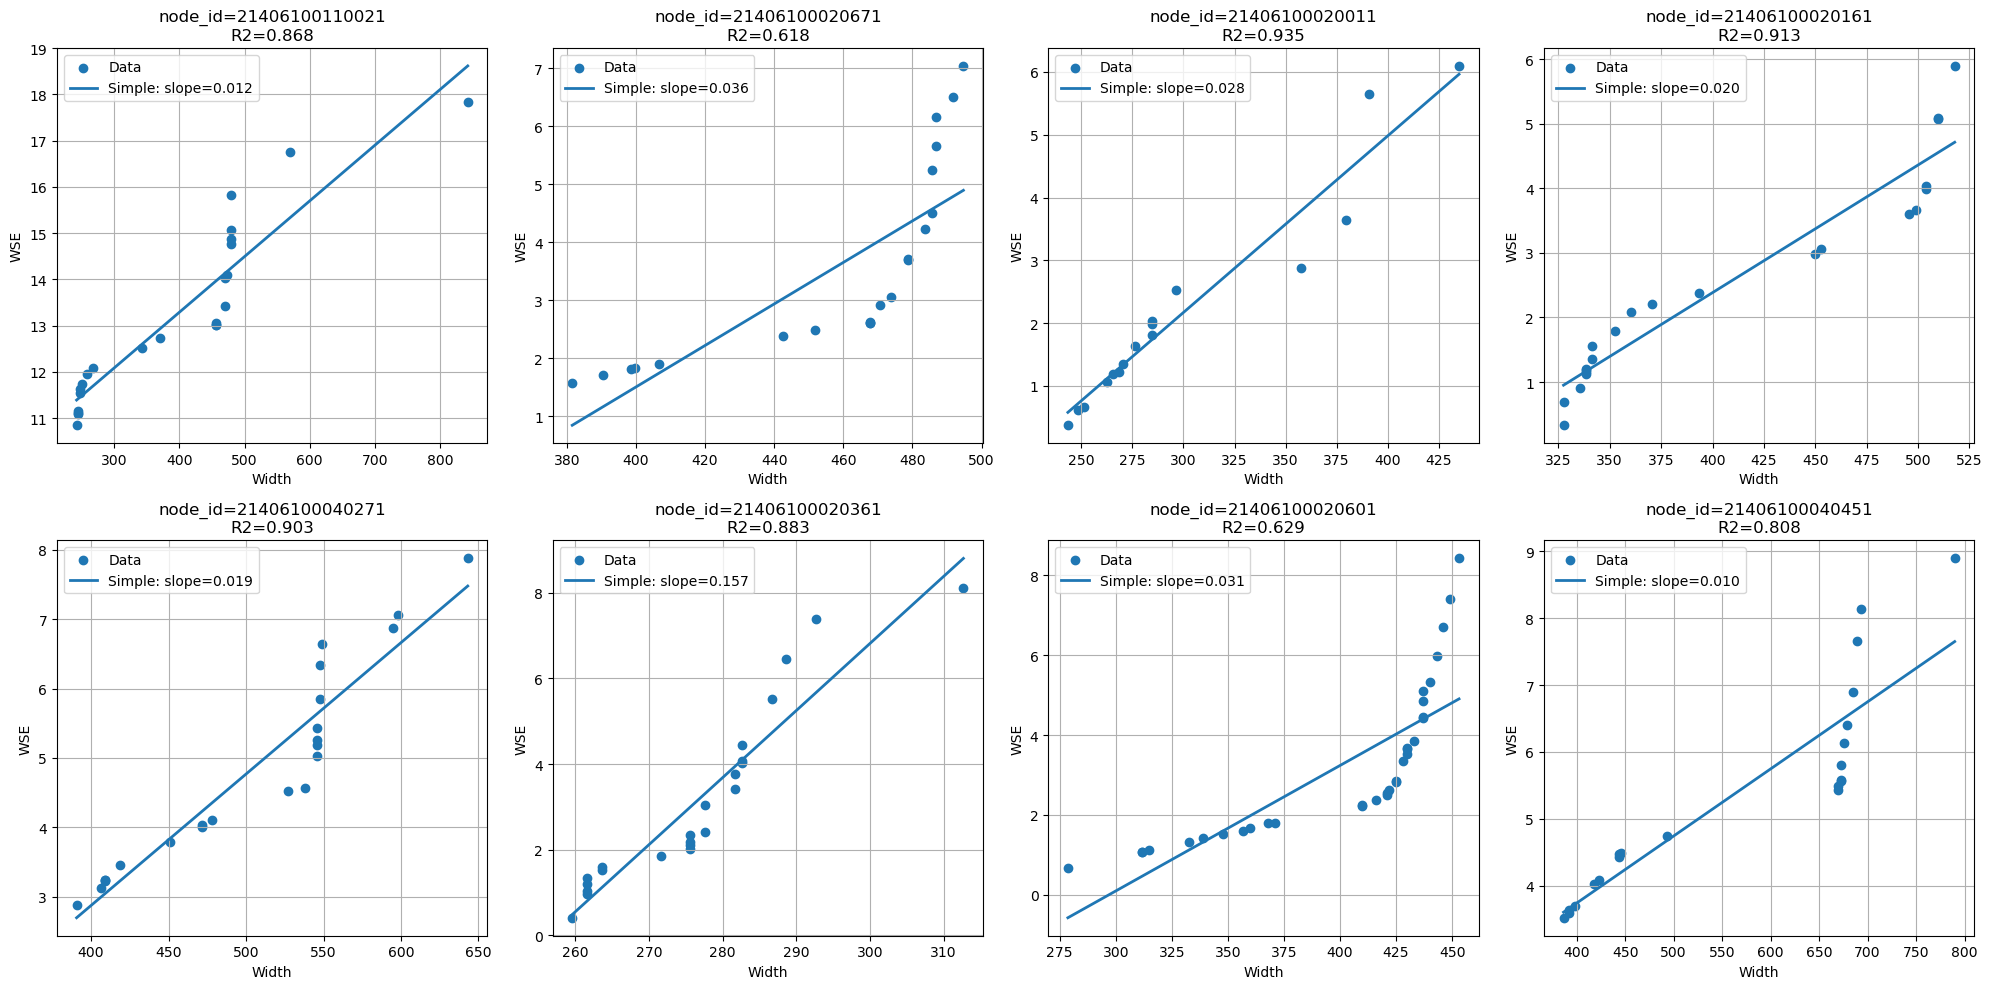

In [25]:
result_df, group_results = groupwise_regression(path2w_wse)
# Optionally, save to CSV
result_df.to_csv(INTERMEDIATE/"Store/Binary_Masks/Po/Bath_simple.csv", index=False)
# Plot 8 random node_id fits
plot_random_regressions(group_results, n=8)

In [19]:
def plot_all_regressions(group_results):
    import math

    n = len(group_results)
    if n == 0:
        print("No groups to plot.")
        return

    ncols = 4
    nrows = math.ceil(n / ncols)

    fig, axs = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows))
    # Ensure axs is always a flat iterable
    if isinstance(axs, np.ndarray):
        axs = axs.flatten()
    else:
        axs = [axs]

    for i, (node_id, (group, res)) in enumerate(group_results.items()):
        X = group['width'].values
        y = group['wse'].values
        ax = axs[i]
        ax.scatter(X, y, label="Data", color='steelblue')

        x_plot = np.linspace(X.min(), X.max(), 300)
        model_type = res['type']

        if model_type == 'simple':
            slope, intercept = res['bath_slope1'], res['intercepts'][0]
            y_fit = slope * x_plot + intercept
            ax.plot(x_plot, y_fit, color='crimson', linewidth=2, label=f"Simple: slope={slope:.4f}")

        elif model_type == 'piecewise':
            slope1, intercept1 = res['bath_slope1'], res['intercepts'][0]
            slope2, intercept2 = res['bath_slope2'], res['intercepts'][1]
            bp = res['bp']
            y_left = slope2 * x_plot + intercept2
            y_right = slope1 * x_plot + intercept1
            ax.plot(x_plot[x_plot < bp], y_left[x_plot < bp], color='crimson', label=f"Left: slope={slope2:.4f}")
            ax.plot(x_plot[x_plot >= bp], y_right[x_plot >= bp], color='crimson', linestyle='--', label=f"Right: slope={slope1:.4f}")
            ax.axvline(bp, color='gray', linestyle=':', label=f"Breakpoint = {bp:.2f}")

        elif model_type == 'piecewise_2bp':
            slope1, slope2, slope3 = res['bath_slope1'], res['bath_slope2'], res['bath_slope3']
            intercept1, intercept2, intercept3 = res['intercepts']
            bp1, bp2 = res['bp']

            y_fit_left = slope3 * x_plot + intercept3
            y_fit_mid = slope2 * x_plot + intercept2
            y_fit_right = slope1 * x_plot + intercept1

            ax.plot(x_plot[x_plot < bp1], y_fit_left[x_plot < bp1], color='crimson', label=f"Left: {slope3:.4f}")
            ax.plot(x_plot[(x_plot >= bp1) & (x_plot < bp2)], y_fit_mid[(x_plot >= bp1) & (x_plot < bp2)], color='crimson', linestyle='--', label=f"Mid: {slope2:.4f}")
            ax.plot(x_plot[x_plot >= bp2], y_fit_right[x_plot >= bp2], color='crimson', linestyle=':', label=f"Right: {slope1:.4f}")
            ax.axvline(bp1, color='gray', linestyle=':', label=f"BP1 = {bp1:.2f}")
            ax.axvline(bp2, color='gray', linestyle=':', label=f"BP2 = {bp2:.2f}")

        ax.set_title(f"node_id={node_id}\nR² = {res['r2']:.2f}")
        ax.set_xlabel("Width")
        ax.set_ylabel("WSE")
        ax.legend()
        ax.grid(True)

    # Remove any extra unused subplots
    total_axes = nrows * ncols
    for j in range(n, total_axes):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()



In [ ]:
plot_all_regressions(group_results)

#### * Merge csv file with Bathymetry slopes with the Regression master csv file

In [35]:
def merge_csv(master_csv, complementary_csv, output_csv):
    """
    Merge two CSV files on 'node_id' and save the result.
    """
    master_df = pd.read_csv(master_csv)
    comp_df = pd.read_csv(complementary_csv)

    # Merge on 'node_id'
    merged_df = master_df.merge(comp_df, on='node_id', how='inner')

    # Save the merged DataFrame
    merged_df.to_csv(output_csv, index=False)
    print(f"Merged CSV saved to {output_csv}")
    
    return merged_df

#### Names of files to use
# Bath_slopes_simple.csv
# Bath_slopes3.csv #Dynamically fitted

path2slope = INTERMEDIATE/"Store/Binary_Masks/Po/Bath_simple.csv"
outpath = INTERMEDIATE/"Store/Validation/csv/Po/reg_slope_simple.csv"
# output dynamically fitted slopes: reg_slope_bath3.csv
# output simple fitted slopes: reg_slope_simple.csv

In [27]:
reg_slope_bath = merge_csv(master_csv_path, path2slope, outpath)

Merged CSV saved to /Volumes/Science_SSD/Dissertation/2_intermediate/Store/Validation/csv/Po/reg_slope_simple.csv


In [28]:
reg_slope_bath

,node_id,time_str,lat,lon,wse,width,node_q_b,dark_frac,ice_clim_f,ice_dyn_f,...,mae_swot,rss_swot,n_obs_swot,swot_ci_low,swot_ci_high,swot_slope_se,bath_slope1,bath_intercept,r2,type
0,21406100010041,2023-08-28T10:22:55Z,44.982918,11.991570,0.27722,299.255367,0.0,0.025268,0.0,-999.0,...,0.697770,16.455585,22,0.010985,0.053363,0.010879,0.123453,-36.114430,0.901224,simple
1,21406100010041,2023-09-08T08:45:54Z,44.982687,11.991480,0.33407,292.043554,2.0,0.008272,0.0,-999.0,...,0.697770,16.455585,22,0.010985,0.053363,0.010879,0.123453,-36.114430,0.901224,simple
2,21406100010041,2023-09-18T07:08:01Z,44.982496,11.991212,0.46715,286.097142,0.0,0.248503,0.0,-999.0,...,0.697770,16.455585,22,0.010985,0.053363,0.010879,0.123453,-36.114430,0.901224,simple
3,21406100010041,2023-10-20T02:16:01Z,44.982585,11.991277,0.57181,294.647331,11.0,0.245025,0.0,-999.0,...,0.697770,16.455585,22,0.010985,0.053363,0.010879,0.123453,-36.114430,0.901224,simple
4,21406100010041,2023-11-09T23:01:06Z,44.982811,11.991529,3.72106,325.590026,3.0,0.000000,0.0,-999.0,...,0.697770,16.455585,22,0.010985,0.053363,0.010879,0.123453,-36.114430,0.901224,simple
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,21406100110541,2024-10-19T17:25:04Z,45.045908,10.751346,19.18738,507.651911,0.0,0.000000,0.0,-999.0,...,0.733113,13.872318,18,0.016150,0.029391,0.003773,0.084722,-9.258917,0.952619,simple
6431,21406100110541,2025-02-01T01:10:25Z,45.044927,10.752107,14.83511,267.817137,0.0,0.000000,0.0,-999.0,...,0.733113,13.872318,18,0.016150,0.029391,0.003773,0.084722,-9.258917,0.952619,simple
6432,21406100110541,2025-03-14T18:40:34Z,45.044950,10.752014,15.56770,251.519514,9.0,0.000000,0.0,-999.0,...,0.733113,13.872318,18,0.016150,0.029391,0.003773,0.084722,-9.258917,0.952619,simple
6433,21406100110541,2025-04-14T13:47:56Z,45.044883,10.751952,13.21390,269.472788,4.0,0.000000,0.0,-999.0,...,0.733113,13.872318,18,0.016150,0.029391,0.003773,0.084722,-9.258917,0.952619,simple


In [29]:
reg_slope_bath_sort = reg_slope_bath.sort_values('p_dist_out', ascending=False).groupby('node_id', as_index=False).first()

In [30]:
## Outlier removal in SWOT and bathymetry
Q1, Q3 = reg_slope_bath_sort['slope1'].quantile([0.25, 0.75])
IQR = Q3 - Q1
l1, u1 = Q1 - 1.5*IQR, Q3 + 1.5*IQR

# bath_slope1 fences
Q1b, Q3b = reg_slope_bath_sort['bath_slope1'].quantile([0.25, 0.75])
IQRb   = Q3b - Q1b
l2, u2 = Q1b - 1.5*IQRb, Q3b + 1.5*IQRb

In [31]:
mask = (
    (reg_slope_bath_sort['slope1']      >= l1) & (reg_slope_bath_sort['slope1']      <= u1) &
    (reg_slope_bath_sort['bath_slope1'] >= l2) & (reg_slope_bath_sort['bath_slope1'] <= u2)
)
removed_iqr = reg_slope_bath_sort.loc[~mask].copy()
removed_iqr['removal_stage'] = 'IQR_fences'
with np.errstate(divide='ignore', invalid='ignore'):
    _rel = 100.0 * (removed_iqr['slope1'] - removed_iqr['bath_slope1']) / removed_iqr['bath_slope1']
removed_iqr['rel_error'] = _rel
removed_iqr['abs_rel_error'] = removed_iqr['rel_error'].abs()

In [32]:
reg_slope_bath_sort = reg_slope_bath_sort[mask]
reg_slope_bath_sort['node_id'].nunique()

181

In [33]:
# --- 0) Work on a copy so you can compare before/after if needed
df = reg_slope_bath_sort.copy()

# --- 1) Compute rel error (percent) in-place-friendly columns
# (safe divide: ignore zero/NaN denominators in the trimming stats)
rel = 100 * (df['slope1'] - df['bath_slope1']) / df['bath_slope1']
df['rel_error'] = rel
df['abs_rel_error'] = rel.abs()

# --- 2) Build a UNIQUE view (like your CDF step) for threshold estimation only
uniq = df[['slope1','bath_slope1','rel_error']].dropna().drop_duplicates(subset=['slope1','bath_slope1'])

# --- 3) MAD right-tail rule (robust, no small-slope dropping)
med  = uniq['rel_error'].median()
mad0 = (uniq['rel_error'] - med).abs().median()
mad  = 1.4826 * mad0                # #1.4826 makes MAD behave like std deviation
k    = 3.0                          # tweakable: 2.5–4. tweak: bigger = keep more, smaller = remove more. it’s analogous to saying “flag anything more than 3σ above the median.”
thr_mad = med + k * mad

mask_out_mad = uniq['rel_error'] > thr_mad

# --- 4) Optional percentile tail shave (set q=None to skip)
q = 0.99                            # top 1% cutoff; set to None to disable
if q is not None:
    thr_q = uniq['rel_error'].quantile(q)
    mask_out_pct = uniq['rel_error'] > thr_q
    mask_out_all = mask_out_mad | mask_out_pct
else:
    mask_out_all = mask_out_mad

# --- 5) Map the unique outliers back to the full df (keep structure)
out_pairs = uniq.loc[mask_out_all, ['slope1','bath_slope1']]
out_pairs['__key__'] = 1
df_key = df[['slope1','bath_slope1']].copy()
df_key['__key__'] = 1

# mark matches
to_drop = df_key.merge(out_pairs, on=['__key__','slope1','bath_slope1'], how='left', indicator=True)
is_rel_outlier = (to_drop['_merge'] == 'both').values

# (optional) keep a flag and a log before dropping
df['is_rel_outlier'] = is_rel_outlier
removed = df[df['is_rel_outlier']].copy()
kept    = df[~df['is_rel_outlier']].copy()

removed = removed.copy()
removed['removal_stage'] = 'MAD_or_pct'

_deleted_cols = ['node_id', 'slope1', 'slope_bathy', 'rel_error', 'abs_rel_error', 'removal_stage']
deleted_nodes = pd.concat(
    [
        removed_iqr.reindex(columns=_deleted_cols, fill_value=np.nan),
        removed.reindex(columns=_deleted_cols, fill_value=np.nan)
    ],
    ignore_index=True
)
# Keep a single record per node_id (remove this line if you prefer all occurrences)
deleted_nodes = deleted_nodes.drop_duplicates(subset=['node_id']).reset_index(drop=True)


# --- 6) Replace reg_slope_bath_sort with the cleaned version (same columns as before)
# If you want the exact original schema, drop the helper columns:
reg_slope_bath_sort = kept.drop(columns=['rel_error','abs_rel_error','is_rel_outlier'])

reg_slope_bath_sort['node_id'].nunique()

167

Error metrics and coefficient of correlations

In [34]:
x = reg_slope_bath_sort['slope1'].values
y = reg_slope_bath_sort['bath_slope1'].values

# Classic metrics
pearson_corr, pearson_p = pearsonr(x, y)
spearman_corr, spearman_p = spearmanr(x, y)
mae = mean_absolute_error(y, x)
rmse = np.sqrt(mean_squared_error(y, x))

# Relative errors
rel_error = 100 * (x - y) / y
mean_bias = np.mean(rel_error)
mean_abs_rel_error = np.mean(np.abs(rel_error))
percentile_68 = np.percentile(np.abs(rel_error), 68)

print(f"Pearson correlation: {pearson_corr:.3f} (p={pearson_p:.2g})")
print(f"Spearman correlation: {spearman_corr:.3f} (p={spearman_p:.2g})")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Relative Error (Bias): {mean_bias:.2f}%")
print(f"Mean Absolute Relative Error: {mean_abs_rel_error:.2f}%")
print(f"68th percentile Absolute Relative Error: {percentile_68:.2f}%")

print(f"\nTotal deleted nodes: {len(deleted_nodes)}")
print("Deleted node_ids:", deleted_nodes['node_id'].tolist())

Pearson correlation: 0.515 (p=1.1e-12)
Spearman correlation: 0.571 (p=8e-16)
Mean Absolute Error (MAE): 0.0089
Root Mean Squared Error (RMSE): 0.0124
Mean Relative Error (Bias): 1.59%
Mean Absolute Relative Error: 35.98%
68th percentile Absolute Relative Error: 44.57%

Total deleted nodes: 43
Deleted node_ids: [21406100010041, 21406100010171, 21406100020011, 21406100020081, 21406100020361, 21406100020371, 21406100020391, 21406100020561, 21406100030191, 21406100030201, 21406100030401, 21406100030461, 21406100030521, 21406100030531, 21406100040251, 21406100040491, 21406100070091, 21406100080191, 21406100100031, 21406100100051, 21406100100091, 21406100100151, 21406100100231, 21406100100241, 21406100100391, 21406100110031, 21406100110101, 21406100110531, 21406100110541, 21406100030241, 21406100030261, 21406100030271, 21406100030291, 21406100030301, 21406100030441, 21406100040341, 21406100040351, 21406100070111, 21406100080201, 21406100080551, 21406100100171, 21406100100651, 21406100110021]

In [ ]:
# ====== Bootstrap correlations + append one river to a CSV (now with 68th percentiles) ======
import numpy as np, csv, os
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_absolute_error, mean_squared_error

# where to accumulate all rivers
OUT_CSV = "/Volumes/Science_SSD/Dissertation/2_intermediate/Store/Validation/csv/Per_river_stats_accumulated_Vok.csv"

BOOTSTRAP_B = 2000   # resamples per river
MIN_SAMPLES = 10     # skip if too few pairs
RNG_SEED    = 42

def _clean_xy(x, y):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    m = np.isfinite(x) & np.isfinite(y)
    return x[m], y[m]

def _abs_rel_error_percent(x, y):
    """Return (signed) relative error (%) and absolute relative error (%), guarding y==0."""
    m = (y != 0) & np.isfinite(x) & np.isfinite(y)
    rel = np.full_like(x, np.nan, dtype=float)
    rel[m] = 100.0 * (x[m] - y[m]) / y[m]   # signed %
    abs_rel = np.abs(rel[np.isfinite(rel)])  # magnitude %
    return rel, abs_rel

def _bootstrap_corrs(x, y, B=1000, seed=None):
    """Bootstrap distributions of Pearson r and Spearman ρ."""
    rng = np.random.default_rng(seed)
    n = len(x)
    pr = np.empty(B); sr = np.empty(B)
    for b in range(B):
        idx = rng.integers(0, n, size=n, endpoint=False)
        xb, yb = x[idx], y[idx]
        # robust to constant resamples
        try:   pr[b] = pearsonr(xb, yb)[0]
        except Exception: pr[b] = np.nan
        try:   sr[b] = spearmanr(xb, yb)[0]
        except Exception: sr[b] = np.nan
    pr = pr[np.isfinite(pr)]
    sr = sr[np.isfinite(sr)]
    return pr, sr

def _qstats(a):
    if a.size == 0: return np.nan, np.nan, np.nan, np.nan
    q1, q2, q3 = np.nanpercentile(a, [25, 50, 75])
    return q1, q2, q3, (q3 - q1)

def append_river_with_bootstrap(label, x, y,
                                out_csv=OUT_CSV,
                                B=BOOTSTRAP_B,
                                min_samples=MIN_SAMPLES,
                                seed=RNG_SEED):
    """
    Compute metrics + bootstrap IQRs of Pearson/Spearman and append one row to CSV.
    Also stores:
      - bias_mean_% (mean signed relative error, %)
      - rel_p68_% (68th percentile of signed relative error, %)
      - abs_rel_p68_% (68th percentile of absolute relative error, %)
      - abs_rel_q1_%, abs_rel_q3_%, abs_rel_iqr_% (magnitude)
    """
    x, y = _clean_xy(x, y)
    n = len(x)
    if n < min_samples:
        print(f"⚠️  Skipped '{label}' (n={n} < {min_samples})")
        return

    # point estimates (originals)
    pearson_r, pearson_p     = pearsonr(x, y)
    spearman_rho, spearman_p = spearmanr(x, y)
    mae  = mean_absolute_error(y, x)
    rmse = np.sqrt(mean_squared_error(y, x))

    # relative errors
    rel, abs_rel = _abs_rel_error_percent(x, y)
    bias_mean   = np.nanmean(rel) if np.any(np.isfinite(rel)) else np.nan          # %
    mare        = np.nanmean(abs_rel) if abs_rel.size else np.nan                 # %
    abs_q1      = np.nanpercentile(abs_rel, 25) if abs_rel.size else np.nan
    abs_q3      = np.nanpercentile(abs_rel, 75) if abs_rel.size else np.nan
    abs_iqr     = (abs_q3 - abs_q1) if abs_rel.size else np.nan
    # 68th percentiles
    rel_p68     = np.nanpercentile(rel, 68) if np.any(np.isfinite(rel)) else np.nan        # signed %
    abs_rel_p68 = np.nanpercentile(abs_rel, 68) if abs_rel.size else np.nan                # magnitude %

    # bootstrap coefficient variability
    pr_dist, sr_dist = _bootstrap_corrs(x, y, B=B, seed=seed)
    p_q1, p_med, p_q3, p_iqr = _qstats(pr_dist)
    s_q1, s_med, s_q3, s_iqr = _qstats(sr_dist)

    print(f"River: {label} (n={n})")
    print(f"  Pearson r = {pearson_r:.3f}  | Bootstrap Q1/med/Q3 = {p_q1:.3f}/{p_med:.3f}/{p_q3:.3f}")
    print(f"  Spearman ρ = {spearman_rho:.3f} | Bootstrap Q1/med/Q3 = {s_q1:.3f}/{s_med:.3f}/{s_q3:.3f}")
    print(f"  MAE={mae:.4f}  RMSE={rmse:.4f}  Bias={bias_mean:.2f}%")
    print(f"  |Rel error|: MARE={mare:.2f}%, Q1={abs_q1:.2f}%, Q3={abs_q3:.2f}%, IQR={abs_iqr:.2f}%")
    print(f"  Rel 68th=% {rel_p68:.2f}   |Rel| 68th=% {abs_rel_p68:.2f}")

    row = {
        "river": str(label), "n": int(n),
        "pearson_r": pearson_r, "pearson_p": pearson_p,
        "spearman_rho": spearman_rho, "spearman_p": spearman_p,

        # bootstrap whiskers for coefficients (to plot)
        "pearson_q1": p_q1, "pearson_q2": p_med, "pearson_q3": p_q3, "pearson_iqr": p_iqr,
        "spearman_q1": s_q1, "spearman_q2": s_med, "spearman_q3": s_q3, "spearman_iqr": s_iqr,

        # error stats (percent)
        "mae": mae, "rmse": rmse,
        "bias_mean_%": bias_mean,           # signed mean bias (%)
        "rel_p68_%": rel_p68,               # 68th percentile of signed relative error (%)
        "abs_rel_p68_%": abs_rel_p68,       # 68th percentile of absolute relative error (%)
        "mare_%": mare,                     # mean absolute relative error (%)
        "abs_rel_q1_%": abs_q1, "abs_rel_q3_%": abs_q3, "abs_rel_iqr_%": abs_iqr,
    }

    file_exists = os.path.isfile(out_csv)
    with open(out_csv, "a", newline="") as f:
        w = csv.DictWriter(f, fieldnames=list(row.keys()))
        if not file_exists:
            w.writeheader()
        w.writerow(row)

    print(f"✔ Appended → {out_csv}\n")



In [ ]:
# Your arrays:
x = reg_slope_bath_sort['slope1'].values
y = reg_slope_bath_sort['bath_slope1'].values  # <- your bath column

# Give this run a label (river name/id)
append_river_with_bootstrap("Atrato", x, y)

#### Figures

In [ ]:
rel_error = 100 * (reg_slope_bath_sort['slope1'] - reg_slope_bath_sort['slope_bathy']) / reg_slope_bath_sort['slope_bathy']
abs_rel_error = np.abs(rel_error)

# Drop duplicates for (slope1, bath_slope1) pairs (optional but matches your logic)
df_rel = pd.DataFrame({
    'slope1': reg_slope_bath_sort['slope1'],
    'slope_bathy': reg_slope_bath_sort['slope_bathy'],
    'rel_error': rel_error,
    'abs_rel_error': abs_rel_error
})
df_rel_unique = df_rel.drop_duplicates(subset=['slope1', 'slope_bathy'], keep='first')

# Sorted arrays for CDFs
bias_sorted = np.sort(df_rel_unique['rel_error'].values)
cdf_bias = np.arange(1, len(bias_sorted) + 1) / len(bias_sorted)

abs_sorted = np.sort(df_rel_unique['abs_rel_error'].values)
cdf_abs = np.arange(1, len(abs_sorted) + 1) / len(abs_sorted)

# Metrics
mean_bias = df_rel_unique['rel_error'].mean()
mean_abs_rel_error = df_rel_unique['abs_rel_error'].mean()
spearman_rho, spearman_p = spearmanr(df_rel_unique['slope1'], df_rel_unique['slope_bathy'])
p68 = np.percentile(df_rel_unique['abs_rel_error'], 68)

# Colors (customize as desired)
color_bias = '#ff5722'
color_abs = '#fbc02d'
color_p68 = 'dimgrey'
color_zero = '#ffa726'
color_mean = '#2979ff'

# ------------------------------------------------------------------------------
# --- Plotting ---
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor('#f5f5f5')

# Plot Relative Error CDF
ax.scatter(
    bias_sorted, cdf_bias,
    color=color_bias,
    label='Relative Error CDF (bias, %)',
    s=70,
    edgecolors='black',
    linewidth=0.5,
    marker='o',
    alpha=0.7
)

# Plot Absolute Relative Error CDF
ax.scatter(
    abs_sorted, cdf_abs,
    color=color_abs,
    label='Absolute Relative Error CDF (%)',
    s=25,
    edgecolors='black',
    linewidth=0.5,
    marker='D',
    alpha=0.9
)

# Zero-Bias vertical line
ax.axvline(
    x=0,
    color=color_zero,
    linestyle='--',
    linewidth=1.8,
    label='Zero Bias'
)

# Mean-Bias vertical line
ax.axvline(
    x=mean_bias,
    color=color_mean,
    linestyle='-.',
    linewidth=2,
    label=f'Mean Bias = {mean_bias:.2f} %'
)

# 68th-percentile vertical/horizontal lines
ax.axvline(
    x=p68,
    color=color_p68,
    linestyle=':',
    linewidth=2.5,
    label=f'|68%ile|: {p68:.2f} %'
)
ax.axhline(
    y=0.68,
    color=color_p68,
    linestyle=':',
    linewidth=2.5
)

# Axis limits and ticks
xmin = np.floor(min(bias_sorted.min(), abs_sorted.min())) - 1
xmax = np.ceil(max(bias_sorted.max(), abs_sorted.max(), p68)) + 1
ax.set_xlim(xmin, xmax)
ax.set_xticks(np.arange(xmin, xmax + 1, 20))

# Labels and title
ax.set_xlabel('Relative Error (%)', fontsize=14)
ax.set_ylabel('Cumulative Probability', fontsize=14)
ax.set_title(
    'CDF of Slope Relative Error, Mean Bias and 68%tile\n',
    fontsize=16,
    weight='bold'
)

# Grid and legend
ax.grid(True, which='major', linestyle='--', alpha=0.5)
ax.legend(fontsize=12, loc='lower right', frameon=True, fancybox=True)

# ------------------------------------------------------------------------------
# --- Marginal KDE plot for bias (inset at top) ---
# ------------------------------------------------------------------------------
ax_kde = inset_axes(
    ax,
    width="100%", height="20%",
    loc='upper center',
    bbox_to_anchor=(0, 1.05, 1, 0.3),
    bbox_transform=ax.transAxes,
    borderpad=0
)
sns.kdeplot(
    x=df_rel_unique['rel_error'],
    ax=ax_kde,
    fill=True,
    linewidth=2,
    alpha=0.3
)
ax_kde.set_xlim(xmin, xmax)
ax_kde.axis('off')

plt.tight_layout()
plt.show()

# --- Print metrics summary ---
print(f"Spearman correlation: {spearman_rho:.3f} (p={spearman_p:.2g})")
print(f"Mean Bias (rel error): {mean_bias:.2f} %")
print(f"Mean Absolute Relative Error: {mean_abs_rel_error:.2f} %")
print(f"68th percentile abs rel error: {p68:.2f} %")



In [ ]:
s1 = reg_slope_bath_sort['slope1']
s2 = reg_slope_bath_sort['slope_bathy']
x  = reg_slope_bath_sort['p_dist_out']

# ─── figure setup ───────────────────────────────────────────────
fig = plt.figure(figsize=(15,6), facecolor='white')
gs  = GridSpec(1, 2, width_ratios=[5, 1.5], wspace=0.15)

# vibrant palette
c1, c2 = '#1f77b4', '#ff7f0e'

# ─── left: line vs. distance with thinner lines ────────────────
ax_main = fig.add_subplot(gs[0])

ax_main.plot(
    x, s1,
    color=c1,
    linestyle='-',
    linewidth=1.5,          # ← thinner line
    marker='o',
    markersize=5,           # ← small markers
    markerfacecolor='white',
    markeredgecolor=c1,
    markeredgewidth=1.0,
    label='SWOT slope'
)
ax_main.plot(
    x, s2,
    color=c2,
    linestyle='--',
    linewidth=1.5,          # ← thinner line
    marker='D',
    markersize=5,           # ← small markers
    markerfacecolor='white',
    markeredgecolor=c2,
    markeredgewidth=1.0,
    label='Bathymetry slope'
)

# gentle fill under curves
ax_main.fill_between(x, s1, alpha=0.1, color=c1)
ax_main.fill_between(x, s2, alpha=0.1, color=c2)

ax_main.set_xlabel('Distance to outlet (m)', fontsize=12, weight='bold')
ax_main.set_ylabel('Slope value', fontsize=12, weight='bold')
ax_main.set_title('Comparison between SWOT and Bathymetry Slopes', fontsize=16, weight='bold')
ax_main.grid(alpha=0.3, linestyle='--')
ax_main.invert_xaxis()
ax_main.legend(loc='upper left', frameon=True, facecolor='white', edgecolor='black')

# ─── right: side boxplot sharing the same y-axis ───────────────
ax_box = fig.add_subplot(gs[1], sharey=ax_main)

bp = ax_box.boxplot(
    [s1, s2],
    positions=[1,2],
    widths=0.6,
    patch_artist=True,
    showfliers=False,
    medianprops=dict(color='black'),
    whiskerprops=dict(color='black'),
    capprops=dict(color='black'),
)

# color the boxes with semi-transparent fill
for patch, color in zip(bp['boxes'], [c1, c2]):
    patch.set_facecolor(color)
    patch.set_alpha(0.3)

# overlay the raw points on top
for i, (y, color) in enumerate(zip([s1, s2], [c1, c2]), start=1):
    xi = np.random.normal(i, 0.04, size=len(y))
    ax_box.scatter(
        xi, y,
        color=color,
        alpha=0.6,
        s=12,
        edgecolors='none',
        zorder=10
    )

ax_box.set_xticks([1,2])
ax_box.set_xticklabels(['SWOT', 'Bathymetry'], fontsize=10, weight='bold')
ax_box.margins(x=0.3)
ax_box.yaxis.tick_right()
ax_box.yaxis.set_label_position("right")
ax_box.grid(True, axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()


In [ ]:
s1 = reg_slope_bath_sort['slope1']
s2 = reg_slope_bath_sort['slope_bathy']

# set up the figure
plt.figure(figsize=(6,6))
plt.scatter(s1, s2, 
            color='red',      # match your SWOT color
            alpha=0.7, 
            edgecolors='none', 
            s=30)

# 1:1 line
lims = [
    np.min([s1.min(), s2.min()]), 
    np.max([s1.max(), s2.max()])
]
plt.plot(lims, lims, 
        ls='--', 
        lw=1.5, 
        color='green', 
        label='1:1 line')

margin = 0.001
low, high = lims

plt.xlim(low - margin, high + margin)
plt.ylim(low - margin, high + margin)

plt.xlabel('SWOT slope', fontsize=12, weight='bold')
plt.ylabel('Bathymetry slope', fontsize=12, weight='bold')
plt.title('SWOT vs. Bathymetry Slopes', fontsize=14, weight='bold')
plt.grid(alpha=0.3, linestyle='--')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
s1 = reg_slope_bath_sort['slope1']           # SWOT slope
s2 = reg_slope_bath_sort['slope_bathy']      # Bathymetry slope

# 1) Hexbin + 1:1 line
plt.figure(figsize=(6,6))
plt.hexbin(s1, s2, gridsize=100, mincnt=1, cmap='Blues')  # no color specified → default cmap
lims = [min(s1.min(), s2.min()), max(s1.max(), s2.max())]
plt.plot(lims, lims, ls='--', lw=1.5, color='green', label='1:1 line')
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel('SWOT slope', fontsize=12, weight='bold')
plt.ylabel('Bathymetry slope', fontsize=12, weight='bold')
plt.title('Hexbin: SWOT vs Bath Slopes', fontsize=14, weight='bold')
plt.legend()
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()


# 2) Bland–Altman (Difference vs Average)
diff = s1 - s2
avg  = 0.5 * (s1 + s2)
mean_diff = diff.mean()
std_diff  = diff.std()

plt.figure(figsize=(6,4))
plt.scatter(avg, diff, s=20, alpha=0.5)
plt.axhline(mean_diff, color='red', linestyle='--', label='Mean diff')
plt.axhline(mean_diff + 1.96*std_diff, color='gray', linestyle=':', label='±1.96σ')
plt.axhline(mean_diff - 1.96*std_diff, color='gray', linestyle=':')
plt.xlabel('Average slope', fontsize=12, weight='bold')
plt.ylabel('Difference (SWOT – Bath)', fontsize=12, weight='bold')
plt.title('Bland–Altman: Difference vs. Average', fontsize=14, weight='bold')
plt.legend()
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()


# 3) Residuals vs SWOT slope
plt.figure(figsize=(6,4))
plt.scatter(s1, diff, s=20, alpha=0.5)
plt.axhline(0, color='black', linestyle='--', lw=1)
plt.xlabel('SWOT slope', fontsize=12, weight='bold')
plt.ylabel('Residual (SWOT – Bath)', fontsize=12, weight='bold')
plt.title('Residuals vs. SWOT Slope', fontsize=14, weight='bold')
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()


plt.show()

# 4) CDF of Absolute Residuals (|SWOT – Bath|)
abs_diff = np.abs(diff)
abs_diff = abs_diff[np.isfinite(abs_diff)]
xs = np.sort(abs_diff)
cdf = np.arange(1, len(xs) + 1) / len(xs)

p50 = np.percentile(abs_diff, 50)
p68 = np.percentile(abs_diff, 68)
p95 = np.percentile(abs_diff, 95)

plt.figure(figsize=(6,4))
plt.plot(xs, cdf, lw=2)
plt.axvline(p68, linestyle='--', label=f'68%tile = {p68:.4f}')
plt.axvline(p50, linestyle=':',  label=f'Median = {p50:.4f}')
plt.axvline(p95, linestyle=':',  label=f'95%tile = {p95:.4f}')
plt.xlabel('|Residual| (|SWOT – Bath|)', fontsize=12, weight='bold')
plt.ylabel('Cumulative Probability', fontsize=12, weight='bold')
plt.title('CDF of Absolute Residuals', fontsize=14, weight='bold')
plt.legend()
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
# (Alternative) Histogram of signed residuals
plt.figure(figsize=(6,4))
plt.hist(diff[np.isfinite(diff)], bins=30, density=True, alpha=0.7)
plt.axvline(mean_diff, linestyle='--', label=f'Mean = {mean_diff:.4f}')
plt.xlabel('Residual (SWOT – Bath)', fontsize=12, weight='bold')
plt.ylabel('Density', fontsize=12, weight='bold')
plt.title('Residual Distribution', fontsize=14, weight='bold')
plt.legend()
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()

# Histogram of Residuals
plt.figure(figsize=(6,4))
plt.hist(diff[np.isfinite(diff)], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(0, color='black', linestyle='--', lw=1, label='Zero line')
plt.axvline(mean_diff, color='red', linestyle='--', lw=1, label=f'Mean = {mean_diff:.4f}')
plt.xlabel('Residual (SWOT – Bath)', fontsize=12, weight='bold')
plt.ylabel('Count', fontsize=12, weight='bold')
plt.title('Histogram of Residuals', fontsize=14, weight='bold')
plt.legend()
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()

import seaborn as sns

# Clean residuals
diff_clean = np.asarray(diff[np.isfinite(diff)])

# Stats
q1, med, q3 = np.percentile(diff_clean, [25, 50, 75])
mean_val    = diff_clean.mean()
p68         = np.percentile(diff_clean, 68)

# Keep comparable limits
ymin = np.percentile(diff_clean, 1)
ymax = np.percentile(diff_clean, 99)
pad  = 0.02 * (ymax - ymin)
ylim = (ymin - pad, ymax + pad)

plt.figure(figsize=(5,4))

# Violin plot with same proportional look
ax = sns.violinplot(
    y=diff_clean,
    inner='box',
    color='lightblue',
    cut=0,
    scale='width',
    bw=0.2,
    linewidth=1.2
)

# Zero line
ax.axhline(0, color='black', linestyle='--', lw=1)

# Markers for stats
ax.scatter(0, mean_val, s=60, marker='D', color='#d62728', zorder=5, label=f"Mean = {mean_val:.4f}")
ax.scatter(0, med,      s=60, marker='o', facecolors='white', edgecolors='black', zorder=5, label=f"Median = {med:.4f}")
ax.scatter(0, q1,       s=80, marker='_', color='#2ca02c', zorder=5, label=f"Q1 = {q1:.4f}")
ax.scatter(0, q3,       s=80, marker='_', color='#1f77b4', zorder=5, label=f"Q3 = {q3:.4f}")
ax.axhline(p68, color='purple', linestyle=':', lw=1.2, label=f"68%tile = {p68:.4f}")

# Labels, limits, legend
ax.set_ylim(ylim)
ax.set_ylabel('Residual (SWOT - Bath)', fontsize=12, weight='bold')
ax.set_title('Residual Distribution Around Zero', fontsize=14, weight='bold')
ax.set_xticks([])

ax.legend(loc='lower left', fontsize=9, frameon=True)  # legend in lower-left

plt.tight_layout()
plt.show()



## Summary

In [ ]:
from itertools import cycle
from matplotlib.lines import Line2D
# -------------------------
# Data
# -------------------------
data = {
    'River': ['Cape Fear', 'Atrato', 'Sacramento', 'Pee Dee', 'Pee Dee up', 'Pee Dee down', 'Po', 'Garonne'],
    'r_simple':  [0.31, 0.61, 0.44, -0.11, -0.25, 0.37, 0.39, 0.24],
    'ρ_simple':  [0.42, 0.62, 0.49, -0.25, -0.15, 0.63, 0.47, 0.34],
    #'r_20':      [0.35, 0.49, 0.56, 0.55, np.nan, np.nan, 0.34, 0.11],
    #'ρ_20':      [0.44, 0.65, 0.57, 0.49, np.nan, np.nan, 0.36, 0.19],
}
df = pd.DataFrame(data)

# -------------------------
# Control which approaches to include
# -------------------------
approaches_to_plot = ["simple", "20"]

# -------------------------
# Reshape into long format
# -------------------------
suffixes = []
for c in df.columns:
    if c.startswith("r_"):
        suf = c[2:]
        if f"ρ_{suf}" in df.columns and suf in approaches_to_plot:
            suffixes.append(suf)

long_rows = []
for s in suffixes:
    tmp = pd.DataFrame({
        'River': df['River'],
        'Approach': s.replace('avrg', 'average'),
        'r': df[f'r_{s}'],
        'ρ': df[f'ρ_{s}'],
    })
    long_rows.append(tmp)

df_long = pd.concat(long_rows, ignore_index=True)

# -------------------------
# Assign unique color+marker per river
# -------------------------
colors = cycle(plt.cm.tab10.colors)   # use tab10 palette cycling
markers = cycle(['o', 's', '^', 'D', 'P', 'X', 'v', '<', '>'])

rivers = df['River'].unique()
river_styles = {}
for river, color, marker in zip(rivers, colors, markers):
    river_styles[river] = {"color": color, "marker": marker}

# -------------------------
# Plot
# -------------------------
fig, ax = plt.subplots(figsize=(12, 10))

for _, row in df_long.iterrows():
    style = river_styles[row['River']]
    ax.scatter(
        row['r'],
        row['ρ'],
        color=style["color"],
        marker=style["marker"],
        s=100,
        edgecolor='black',
        linewidth=0.7
    )

# Axes, style
ax.set_xlabel('r', fontsize=12, fontweight='bold')
ax.set_ylabel('ρ', fontsize=12, fontweight='bold')
ax.set_title('r vs ρ by River', fontsize=14, fontweight='bold')
ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)
ax.axvline(0, color='gray', linestyle='--', linewidth=0.8)
ax.set_xlim(-0.5, 1.05)
ax.set_ylim(-0.5, 1.05)
ax.grid(True, linestyle='--', alpha=0.5)

# Legend (only rivers)
river_handles = [
    Line2D([0], [0], marker=style["marker"], color='w',
           label=river, markerfacecolor=style["color"],
           markeredgecolor='black', markersize=10)
    for river, style in river_styles.items()
]
ax.legend(handles=river_handles, title="Rivers", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()

In [ ]:
from matplotlib.colors import TwoSlopeNorm
from matplotlib.lines import Line2D
from matplotlib.collections import LineCollection
# =========================
# Config
# =========================
threshold = 0.40
outline_color = 'limegreen'
dash_on, dash_off = 1.5, 2.0  # dotted look
lw = 2

# =========================
# Data
# =========================
data = {
    'River': ['Cape Fear', 'Atrato', 'Sacramento', 'Pee Dee', 'Po', 'Garonne'],
    'r_40':  [0.44, 0.62, 0.64, 0.54, 0.21, 0.18],
    'ρ_40':  [0.42, 0.65, 0.67, 0.52, 0.30, 0.08],
    'r_80':  [0.41, 0.83, 0.45, 0.1, 0.34, 0.24],
    'ρ_80':  [0.37, 0.70, 0.51, -0.08, 0.36, 0.06],
}
df = pd.DataFrame(data).set_index('River')
df = df[['r_40', 'ρ_40', 'r_80', 'ρ_80']]

# =========================
# Heatmap
# =========================
vals = df.values
vmax = np.nanmax(np.abs(vals))
norm = TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=vmax)

fig, ax = plt.subplots(figsize=(7.8, 5.0))
im = ax.imshow(vals, aspect='auto', cmap='RdBu_r', norm=norm, origin='upper')

ax.set_xticks(np.arange(df.shape[1]))
ax.set_xticklabels(df.columns, fontsize=11, fontweight='bold')
ax.set_yticks(np.arange(df.shape[0]))
ax.set_yticklabels(df.index, fontsize=11)

# annotate values
for i in range(vals.shape[0]):
    for j in range(vals.shape[1]):
        ax.text(j, i, f"{vals[i, j]:.2f}",
                ha='center', va='center', fontsize=9,
                color='black' if abs(vals[i, j]) < vmax*0.55 else 'white')

ax.set_title('Correlation Heatmap (centered at 0)', fontsize=13, fontweight='bold', pad=10)
ax.set_xlabel('metric@Segment Width', fontsize=11, fontweight='bold')
ax.set_ylabel('River', fontsize=11, fontweight='bold')
ax.set_frame_on(False)

cbar = fig.colorbar(im, ax=ax, shrink=0.9, pad=0.02)
cbar.set_label('Correlation', fontsize=11, fontweight='bold')

# =========================
# Boxy perimeter for r > threshold OR ρ > threshold
# =========================
mask = vals > threshold  # includes both Pearson and Spearman

rows, cols = mask.shape
edges = set()

def add_edge(p1, p2):
    edges.add((p1, p2) if p1 < p2 else (p2, p1))

for i in range(rows):
    for j in range(cols):
        if not mask[i, j]:
            continue
        x0, x1 = j - 0.5, j + 0.5
        y0, y1 = i - 0.5, i + 0.5
        if i == 0 or not mask[i-1, j]:      # top
            add_edge((x0, y0), (x1, y0))
        if i == rows-1 or not mask[i+1, j]: # bottom
            add_edge((x0, y1), (x1, y1))
        if j == 0 or not mask[i, j-1]:      # left
            add_edge((x0, y0), (x0, y1))
        if j == cols-1 or not mask[i, j+1]: # right
            add_edge((x1, y0), (x1, y1))

segments = [list(edge) for edge in edges]

if segments:
    lc = LineCollection(
        segments,
        colors=outline_color,
        linewidths=3,
        linestyles=(0, (dash_on, dash_off)),
        capstyle='butt',
        joinstyle='miter',
        zorder=3,
    )
    ax.add_collection(lc)

# keep full pixel grid visible
ax.set_xlim(-0.5, cols - 0.5)
ax.set_ylim(rows - 0.5, -0.5)

# =========================
# Legend outside the axes
# =========================
outline_handle = Line2D([0], [0], color=outline_color, lw=lw, linestyle=(0, (dash_on, dash_off)))
fig.legend([outline_handle], [f'Pearson or Spearman > {threshold:.2f}'],
           loc='lower right', bbox_to_anchor=(0.98, -0.05), frameon=False)

plt.tight_layout()
plt.show()

In [ ]:
# -------------------------
# Data (keep all approaches; lengths may differ)
# -------------------------
data = {
    'River':  ['Cape Fear','Atrato','Sacramento','Pee Dee', 'Pee Dee up', 'Pee Dee down', 'Po','Garonne'],
    'bias_simple':[-44.4, 20.4, -16.3, -11.9, 18.7, -72.9, 12.0, -80.0],
    'p68_simple': [75.6, 51.3,  53.8,  76.5, 74.4, 77.3, 49.0,  88.7],
    #'bias_avrg': [-54.6, 19.6, -26.8, -26.2,  13.7, -81.2],          # shorter
    #'p68_avrg':  [78.4, 47.9,  41.5,  70.6,  58.5,  89.2],           # shorter
    #'bias_20':   [-71.0, 54.3, -26.7, -38.6, 0.12, -83.1, np.nan, np.nan],
    #'p68_20':    [81.9, 95.1,  69.5,  56.0,  59.9, 89.6, np.nan, np.nan],
}

# Build base df and safely align any shorter columns
df = pd.DataFrame({'River': data['River']})
for k, v in data.items():
    if k == 'River': 
        continue
    s = pd.Series(v)
    df[k] = s.reindex(range(len(df))).values  # pad with NaN to match length

# -------------------------
# Choose which approaches to include (ignore 'avrg')
# -------------------------
INCLUDE = ['simple', '20']   # <- change here to toggle approaches
# INCLUDE = ['simple']       # e.g., only simple
# INCLUDE = ['simple', 'avrg', '20']  # to include all

# -------------------------
# Auto-detect suffixes, then filter by INCLUDE
# -------------------------
suffixes = []
for c in df.columns:
    if c.startswith('bias_'):
        suf = c[5:]
        if f'p68_{suf}' in df.columns:
            suffixes.append(suf)

if INCLUDE is not None:
    suffixes = [s for s in suffixes if s in INCLUDE]

# -------------------------
# Long format for plotting
# -------------------------
long_rows = []
for s in suffixes:
    tmp = pd.DataFrame({
        'River': df['River'],
        'Approach': s.replace('avrg', 'average'),
        'Bias': df[f'bias_{s}'],
        'P68':  df[f'p68_{s}'],
    })
    long_rows.append(tmp)

long = pd.concat(long_rows, ignore_index=True)

# Drop rows that are all-NaN for the selected approach
long = long.dropna(subset=['Bias', 'P68'], how='all')

# -------------------------
# Assign unique color + marker per river (no approach legend)
# -------------------------
rivers = df['River'].unique()
colors = cycle(plt.cm.tab10.colors)
markers = cycle(['o','s','^','D','P','X','v','<','>'])

river_styles = {}
for river, color, marker in zip(rivers, colors, markers):
    river_styles[river] = {'color': color, 'marker': marker}

# -------------------------
# Plot
# -------------------------
fig, ax = plt.subplots(figsize=(8.6, 6.4))

for _, row in long.iterrows():
    st = river_styles[row['River']]
    ax.scatter(
        row['Bias'], row['P68'],
        s=120, alpha=0.9,
        color=st['color'],
        marker=st['marker'],
        edgecolor='black', linewidth=0.7
    )

# Axes & style
ax.axvline(0, linestyle='--', linewidth=0.8, color='gray')
ax.set_xlabel('Bias (%)', fontweight='bold')
ax.set_ylabel('68th Percentile Error (%)', fontweight='bold')
ax.set_title('Bias vs 68%ile Error — by River', fontweight='bold')
ax.grid(True, linestyle=':', alpha=0.35)

# Legend: only rivers
river_handles = [
    Line2D([0], [0], marker=st['marker'], color='w', label=river,
           markerfacecolor=st['color'], markeredgecolor='black', markersize=10)
    for river, st in river_styles.items()
]
ax.legend(handles=river_handles, title='Rivers',
          bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)

plt.tight_layout()
plt.show()


## Width variability

Testing how strongly width variabilty affects errors, bias and correlations

In [ ]:
df_swot = pd.read_csv(swot_simple)
to_exclude = deleted_nodes['node_id'].unique().tolist()
df_swot = df_swot[~df_swot['node_id'].isin(to_exclude)]

In [ ]:
df_bath = pd.read_csv(path2w_wse)
to_exclude_bath = deleted_nodes['node_id'].unique().tolist()
df_bath = df_bath[~df_bath['node_id'].isin(to_exclude_bath)]

In [ ]:
def coefvar(dframe):
    cv_width = dframe.groupby('node_id')['width'].agg(lambda x: x.std()/x.mean())
    return cv_width.reset_index().rename(columns={"width": "CV_width"})

In [ ]:
cv = coefvar(df_bath)

In [ ]:
df_bath

In [ ]:
cv

In [ ]:
mean_cv = cv['CV_width'].mean()
mean_cv

In [ ]:
CV_rivers ={
    'River':  ["Cape Fear", "Atrato", "Sacramento", "Pee Dee","Pee Dee up", "Pee Dee down", "Po", "Garonne"],
    'cv_Bath_group':      [0.16, 0.42, 0.30, 0.29, 0.09, 0.95, 0.20, 0.07],
    #'cv_Bath_all':        [0.33, 0.55, 0.39, 0.42, 0.31, 0.11],
    'cv_swot_group':      [0.22, 0.26, 0.20, 0.42, 0.09, 0.87, 0.17, 0.27],
    #'cv_swot_all':      [0.33, 0.37, 0.35, 0.86, 0.31, 0.33],
    'ρ_simple':       [0.42, 0.62, 0.49, -0.25, -0.15, 0.63, 0.47, 0.34],
    #'ρ_avrg':       [0.31, 0.74, 0.67, 0.06,0.39, 0.23],
    #'ρ_20%':       [0.44, 0.54, 0.57, 0.49, 0.36, 0.19],
    #'ρ_23%':       [0.44, 0.60 ,0.53, 0.33, 0.38, 0.19],
    #'ρ_25%':       [0.44, 0.59, 0.57, 0.29, 0.39, 0.19],
    #'ρ_30%':       [0.44, 0.63, 0.69, 0.17, 0.39,0.19],
    'bias(%) simple': [-44.4, 20.4, -16.3, -12.6, 18.7, -72.9, 12.0, -80.0],
    #'bias(%) avrg': [-54.6, 19.6, -26.8, -26.2, 13.7, -81.2],
    #'bias(%) 20%': [-71.0, 54.3, -26.7, -34.9, 0.12, -83.11],
    #'bias(%) 23%': [-70.95, 32.19, -31.52, -25.26, 1.77, -82.62],
    #'bias(%) 25%': [-70.95, 43.42, -30.00, -13.78, 1.60, -82.62],
    #'bias(%) 30%': [-70.95, 27.68, -28.89, -3.96, 14.07, -82.62],
    '68"%"ile simple': [75.6, 51.3, 53.8, 76.8, 74.4, 77.3, 49.0, 88.7],
    #'68"%"ile avrg': [78.4, 47.9, 41.5, 70.6, 58.5, 89.2],
    #'68"%"ile 20%': [81.9, 95.1, 69.5, 61.0, 60.0, 89.6],
    #'68"%"ile 23%': [81.91, 73.08, 58.52, 58.14, 56.04, 89.63],
    #'68"%"ile 25%': [81.91, 91.57, 56.98, 73.22, 52.98, 89.63],
    #'68"%"ile 30%': [81.91, 81.39, 53.38, 76.25, 58.63, 89.63],
}

summary_cv = pd.DataFrame(CV_rivers)

In [ ]:
from matplotlib.ticker import MultipleLocator
import yaml
import re, fnmatch

# --- column normalization (accept your original headers) ---
RENAME_MAP = {
    'ρ_simple': 'rho_simple',
    'ρ_20%': 'rho_20pct',
    'bias(%) simple': 'bias_simple_pct',
    'bias(%) 20%': 'bias_20_pct',
    '68"%"ile simple': 'p68_simple_pct',
    '68"%"ile 20%': 'p68_20_pct',
}

def load_data(csv_path: str) -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    df = df.rename(columns=RENAME_MAP)
    # keep everything; just sanity-check key CV columns exist
    expected_any = {'cv_swot_group'}
    missing = [c for c in expected_any if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")
    return df

def load_config(yaml_path: str|None=None, fallback: dict|None=None) -> dict:
    if yaml_path:
        with open(yaml_path, 'r') as f:
            cfg = yaml.safe_load(f)
    else:
        cfg = fallback or {}
    # Defaults (unchanged behavior unless you set them in YAML)
    cfg.setdefault('x_col', 'cv_swot_group')
    cfg.setdefault('y_cols', ['rho_simple','rho_20pct'])
    cfg.setdefault('percent_axis', True)
    cfg.setdefault('label_offset', {})
    cfg.setdefault('x_max', 1.8)
    cfg.setdefault('y_mode', 'auto')                     # 'auto' | 'percent' | 'fraction'
    cfg.setdefault('fraction_as_percent_labels', False)
    # NEW: optional filter for plotting only specific rivers (keeps the rest of the data)
    cfg.setdefault('include_rivers', None)               # e.g., ['Pee Dee up','Pee Dee down']
    return cfg

def expand_y_cols(df: pd.DataFrame, patterns) -> list[str]:
    cols = set()
    for pat in patterns:
        if isinstance(pat, str) and pat.startswith('/') and pat.endswith('/'):
            rx = re.compile(pat[1:-1])
            cols |= {c for c in df.columns if rx.search(c)}
        else:
            cols |= set(fnmatch.filter(df.columns, pat))
    return [c for c in df.columns if c in cols]

def is_bias(col: str) -> bool:
    return 'bias' in col

def _classify(col: str) -> str:
    """
    Return one of: 'bias_pct' (−100..100), 'p68_pct' (0..100), 'fraction' (−0.3..1)
    """
    if col.startswith('bias_') and col.endswith('_pct'):
        return 'bias_pct'
    if col.startswith('p68_') and col.endswith('_pct'):
        return 'p68_pct'
    if col.startswith('rho_'):
        return 'fraction'
    return 'bias_pct' if (is_bias(col) or col.endswith('_pct')) else 'fraction'

def plot_panels(df: pd.DataFrame, cfg: dict):
    X_COL = cfg['x_col']
    y_cols = expand_y_cols(df, cfg['y_cols'])
    PERCENT = bool(cfg['percent_axis'])
    LABEL_OFFSET = cfg['label_offset']
    x_max = float(cfg.get('x_max', 1.8))
    Y_MODE = cfg.get('y_mode', 'auto')
    FRAC_AS_PCT = bool(cfg.get('fraction_as_percent_labels', False))
    INCLUDE_RIVERS = cfg.get('include_rivers', None)

    # --- NEW: filter only for plotting (does not modify the original df) ---
    df_plot = df if not INCLUDE_RIVERS else df[df['River'].isin(INCLUDE_RIVERS)].copy()
    if df_plot.empty:
        raise ValueError("No rows to plot after applying include_rivers filter.")
    for c in [X_COL, 'River', *y_cols]:
        if c not in df_plot.columns:
            raise KeyError(f"Column '{c}' not found after normalization.")

    # prepare figure with up to 2 panels (as your current code)
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    axes = axes.flatten()

    for ax, col in zip(axes, y_cols):
        x = df_plot[X_COL]
        y = df_plot[col]

        ax.scatter(x, y, s=100, zorder=2)

        # River labels
        for xi, yi, name in zip(x, y, df_plot['River']):
            dx, dy = LABEL_OFFSET.get(name, (10, 6))
            ax.annotate(
                name, xy=(xi, yi), xytext=(dx, dy), textcoords='offset points',
                ha='left' if dx >= 0 else 'right', va='center', fontsize=12,
                arrowprops=dict(arrowstyle='-', lw=0.7, alpha=0.7),
                zorder=0, clip_on=False
            )

        ax.set_xlim(0, x_max)

        # ---- Y axis behavior (unchanged) ----
        if Y_MODE == 'percent':
            ax.set_ylim(-100, 100)
            ax.yaxis.set_major_locator(MultipleLocator(20))
            ax.yaxis.set_major_formatter(PercentFormatter(xmax=100))

        elif Y_MODE == 'fraction':
            ax.set_ylim(-0.3, 1.0)
            ax.yaxis.set_major_locator(MultipleLocator(0.2))
            if FRAC_AS_PCT:
                ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
            else:
                ax.yaxis.set_major_formatter('{x:.2f}')

        else:
            kind = _classify(col)
            if kind == 'bias_pct':
                ax.set_ylim(-100, 100)
                ax.yaxis.set_major_locator(MultipleLocator(20))
                ax.yaxis.set_major_formatter(PercentFormatter(xmax=100) if PERCENT else '{x:.0f}')
            elif kind == 'p68_pct':
                ax.set_ylim(0, 100)
                ax.yaxis.set_major_locator(MultipleLocator(10))
                ax.yaxis.set_major_formatter(PercentFormatter(xmax=100) if PERCENT else '{x:.0f}')
            else:
                ax.set_ylim(-0.3, 1.0)
                ax.yaxis.set_major_locator(MultipleLocator(0.2))
                if FRAC_AS_PCT or PERCENT:
                    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
                else:
                    ax.yaxis.set_major_formatter('{x:.2f}')

        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.set_xlabel('CV', fontsize=14)
        ax.set_ylabel(col, fontsize=14)

        ax.grid(True, which='major', linestyle='--', linewidth=0.8, alpha=0.5)
        ax.minorticks_on()
        ax.grid(True, which='minor', linestyle=':', linewidth=0.6, alpha=0.35)

        # Stats (on visible points)
        try:
            r_s, _ = spearmanr(x, y)
            r_p, _ = pearsonr(x, y)
            ax.text(0.95, 0.05, f"ρ = {r_s:.2f}",
                    transform=ax.transAxes, ha='right', va='bottom',
                    fontsize=10, fontweight='bold')
            ax.text(0.95, 0.05, f"r = {r_p:.2f}",
                    transform=ax.transAxes, ha='right', va='top',
                    fontsize=10, fontweight='bold')
        except Exception:
            pass

    # Hide unused panels if fewer y_cols
    for ax in axes[len(y_cols):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
df_rivers = load_data(INTERMEDIATE/"Store/Figures/cv_rivers.csv")
cfg = load_config(INTERMEDIATE/"STORE/Figures/plot_config.yaml")  # or load_config(fallback={"y_cols":["rho_*"]})
plot_panels(df_rivers, cfg)

In [ ]:
data = {
    'River':  ["Cape Fear", "Atrato", "Sacramento", "Pee Dee Down", "Po", "Garonne"],
    'cv_swot_group':      [0.22, 0.26, 0.20, 0.87, 0.17, 0.27],
    'cv_Bath_group':      [0.16, 0.42, 0.30, 0.95, 0.20, 0.07],
    'cv_swot_all':      [0.33, 0.37, 0.35, 0.86, 0.31, 0.33],
    'cv_Bath_all':        [0.33, 0.55, 0.39, 0.42, 0.31, 0.11]
}
df = pd.DataFrame(data)

# --- Scatter plot ---
fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(df['cv_swot_group'], df['cv_Bath_group'], s=100, zorder=2)

# Add river names as labels
for i, row in df.iterrows():
    ax.text(row['cv_swot_group'] + 0.01,  # small x-offset
            row['cv_Bath_group'] + 0.01,  # use Bath_group to match y-axis
            row['River'],
            fontsize=10, va='center', ha='left')

# Axis labels
ax.set_xlabel("CV SWOT group", fontsize=14)
ax.set_ylabel("CV Bath group", fontsize=14)

# Grid
ax.grid(True, linestyle="--", alpha=0.6)

# Correlation stats (between same x and y you plotted)
rho_s, p_s = spearmanr(df['cv_swot_group'], df['cv_Bath_group'])
rho_p, p_p = pearsonr(df['cv_swot_group'], df['cv_Bath_group'])

ax.text(0.95, 0.05, f"ρ = {rho_s:.2f}\nr = {rho_p:.2f}",
        transform=ax.transAxes, ha='right', va='bottom',
        fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

x = summary_cv['cv_Bath_group']
y = summary_cv['cv_swot_group']

# Scatter
ax.scatter(x, y, s=100, zorder=2)

# River labels
for xi, yi, name in zip(x, y, summary_cv['River']):
    dx, dy = LABEL_OFFSET.get(name, (10, 6))
    ax.annotate(
        name, xy=(xi, yi), xytext=(dx, dy),
        textcoords='offset points',
        ha='left' if dx >= 0 else 'right',
        va='center', fontsize=12,
        arrowprops=dict(arrowstyle='-', lw=0.7, alpha=0.7),
        zorder=0, clip_on=False
    )

# Axes
ax.set_xlim(0, 0.5)
ax.set_ylim(0, 0.5)
ax.set_xlabel("CV Bathymetry Group", fontsize=14)
ax.set_ylabel("CV SWOT Group", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)

# Grid
ax.grid(True, which='major', linestyle='--', linewidth=0.8, alpha=0.5)
ax.minorticks_on()
ax.grid(True, which='minor', linestyle=':', linewidth=0.6, alpha=0.35)

# Correlation between them
r, _ = spearmanr(x, y)
ax.text(0.95, 0.05, f"ρ = {r:.2f}",
        transform=ax.transAxes, ha='right', va='bottom',
        fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


In [ ]:
# -----------------------------
# Column selection & label offsets
# -----------------------------
bias_cols = summary_cv.filter(regex=r'^bias\(%\)\s*\d+%$').columns.tolist()

LABEL_OFFSET = {
    "Cape Fear": (-10, 10),
    "Po":        ( 10, 10),
    "Sacramento":( 10, 10),
    "Atrato":    ( 10, 10),
    "Pee Dee":   (-10, 10),
    "Garonne":   ( 10, -4),
}

# X series to compare (name, legend label, marker)
x_cols = [
    ('cv_swot_all',   'SWOT all',   'o'),
    ('cv_swot_group', 'SWOT group', 's'),
    ('cv_Bath_all',   'Bath all',   '^'),
    ('cv_Bath_group', 'Bath group', 'D'),
]

# -----------------------------
# Plot
# -----------------------------
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for ax, col in zip(axes, bias_cols):
    y = summary_cv[col]

    ann_lines = []  # lines for correlation textbox

    # Plot each CV series
    for j, (xname, label, marker) in enumerate(x_cols):
        x = summary_cv[xname]
        ax.scatter(x, y, s=90, marker=marker, label=label, zorder=2)

        # Correlations for this series
        rs, _ = spearmanr(x, y)
        rp, _ = pearsonr(x, y)
        ann_lines.append(f"{label}: ρ={rs:.2f}, r={rp:.2f}")

        # Add river labels only once (first series) to avoid 4x duplicates
        if j == 0:
            for xi, yi, name in zip(x, y, summary_cv['River']):
                dx, dy = LABEL_OFFSET.get(name, (10, 6))
                ax.annotate(
                    name, xy=(xi, yi), xytext=(dx, dy),
                    textcoords='offset points',
                    ha='left' if dx >= 0 else 'right',
                    va='center', fontsize=10,
                    arrowprops=dict(arrowstyle='-', lw=0.6, alpha=0.6),
                    zorder=0, clip_on=False
                )

    # Axes styling
    ax.set_xlim(0, 1.2)  # up to 1.18 in cv_swot_all
    ax.set_ylim(-100, 100)
    ax.yaxis.set_major_locator(MultipleLocator(20))
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))  # show -100%..100%
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xlabel('CV', fontsize=14)
    ax.set_ylabel(col, fontsize=14)

    # Grid
    ax.grid(True, which='major', linestyle='--', linewidth=0.8, alpha=0.5)
    ax.minorticks_on()
    ax.grid(True, which='minor', linestyle=':', linewidth=0.6, alpha=0.35)

    # Correlation textbox (bottom-right)
    ax.text(
        0.98, 0.02, "\n".join(ann_lines),
        transform=ax.transAxes, ha='right', va='bottom',
        fontsize=9, fontweight='bold',
        zorder=10, clip_on=False,
        bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.6)
    )

    # Legend
    ax.legend(loc='upper left', fontsize=9, frameon=True, framealpha=0.8)

# Hide unused panels if any (not needed here but safe)
for ax in axes[len(bias_cols):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

### What about XTRK_dist

In [ ]:
simple = pd.read_csv(swot_simple)
simple = simple.dropna(subset=['node_id', 'xtrk_dist', 'spearman_corr']).copy()
simple['xtrk_dist'] = pd.to_numeric(simple['xtrk_dist'], errors='coerce')
simple['spearman_corr'] = pd.to_numeric(simple['spearman_corr'], errors='coerce')
simple = simple.dropna(subset=['xtrk_dist', 'spearman_corr'])

# --- One row per node_id: mean xtrk_dist + first spearman_corr (by current row order) ---
agg = (
    simple
    .groupby('node_id', as_index=False)
    .agg(
        xtrk_dist_mean=('xtrk_dist', 'mean'),
        spearman_corr_first=('spearman_corr', 'first')
    )
)

# --- Scatter plot (points only) ---
plt.figure(figsize=(7, 6))
plt.scatter(agg['xtrk_dist_mean'], agg['spearman_corr_first'], s=60, alpha=0.7, edgecolor='k')

plt.xlabel("Mean Cross-track Distance by node_id", fontsize=12)
plt.ylabel("Spearman Correlation (first per node_id)", fontsize=12)
plt.title("Spearman Correlation vs Mean Cross-track Distance", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [ ]:
def mean_xtrk(dframe):
    mean_dist = dframe.groupby('node_id')['xtrk_dist'].mean()
    return mean_dist.reset_index().rename(columns={"xtrk_dist": "mean_xtrk_dist"})


In [ ]:
xtrk = mean_xtrk(simple)
xtrk['mean_xtrk_dist'].mean()

In [ ]:
print(xtrk)

## ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

## ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [ ]:
from matplotlib.lines import Line2D
def plot_river_grid(df, river_order=None, suptitle="r vs ρ across rivers"):
    required = {"river", "setting", "r", "rho", "r_p", "rho_p"}
    if missing := required - set(df.columns):
        raise ValueError(f"Missing columns: {missing}")

    rivers = list(pd.unique(df["river"]))
    if river_order:
        rivers = [r for r in river_order if r in rivers] + [r for r in pd.unique(df["river"]) if r not in river_order]
    rivers = rivers[:6]

    # Color map per setting
    setting_order = list(pd.unique(df["setting"].astype(str)))
    cmap = plt.cm.get_cmap("tab10", max(1, len(setting_order)))
    color_map = {s: cmap(i) for i, s in enumerate(setting_order)}

    # Global axis limits
    xmin = min(0.0, df["r"].min()) - 0.02
    xmax = max(1.0, df["r"].max()) + 0.02
    ymin = min(0.0, df["rho"].min()) - 0.02
    ymax = max(1.0, df["rho"].max()) + 0.02

    # Grid
    fig, axes = plt.subplots(2, 3, figsize=(13, 7), dpi=140, sharex=True, sharey=True)
    axes = axes.ravel()

    setting_handles = {}

    for ax, river in zip(axes, rivers):
        sub = df[df["river"] == river]

        for setting, chunk in sub.groupby("setting"):
            col = color_map[setting]
            for _, row in chunk.iterrows():
                nonsig = (row["r_p"] > 0.05) or (row["rho_p"] > 0.05)
                marker = "x" if nonsig else "o"
                kwargs = dict(s=70, marker=marker)
                if nonsig:
                    kwargs.update(color=col, linewidth=1.0, alpha=0.95)
                else:
                    kwargs.update(facecolor=col, edgecolor="black", linewidth=0.6, alpha=0.95)
                ax.scatter(row["r"], row["rho"], **kwargs)

            if setting not in setting_handles:
                setting_handles[setting] = Line2D(
                    [], [], marker='o', linestyle='None',
                    markerfacecolor=col, markeredgecolor='black',
                    markersize=7, label=str(setting)
                )

        ax.set_title(str(river), fontsize=11)
        ax.grid(True, linestyle=":", alpha=0.35)
        ax.axvline(0, lw=0.6, alpha=0.4)
        ax.axhline(0, lw=0.6, alpha=0.4)
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)

    for i, ax in enumerate(axes):
        if i % 3 == 0:
            ax.set_ylabel("ρ (Spearman)")
        if i >= 3:
            ax.set_xlabel("r (Pearson)")

    for j in range(len(rivers), 6):
        axes[j].set_visible(False)

    # Legends outside
    settings_legend = fig.legend(
        handles=[setting_handles[s] for s in setting_order if s in setting_handles],
        labels=[s for s in setting_order if s in setting_handles],
        title="Segment width",
        loc="lower center",
        ncol=min(5, len(setting_handles)),
        frameon=True,
        bbox_to_anchor=(0.5, -0.12)   # OUTSIDE bottom
    )

    signif_handles = [
        Line2D([], [], marker='o', linestyle='None',
               markerfacecolor='white', markeredgecolor='black',
               markersize=7, markeredgewidth=0.8, label='p ≤ 0.05 (significant)'),
        Line2D([], [], marker='x', linestyle='None',
               color='black', markersize=7, label='p > 0.05 (not significant)')
    ]
    fig.legend(
        handles=signif_handles,
        loc="center left",
        frameon=True,
        title="Significance",
        bbox_to_anchor=(1.01, 0.5)   # OUTSIDE right
    )

    fig.suptitle(suptitle, y=0.99, fontsize=14)
    plt.tight_layout(rect=[0.02, 0.05, 0.9, 0.95])  # leave room
    plt.show()

In [ ]:
df = pd.DataFrame([
     {"river":"Cape Fear","setting":"40 m","r":0.44,"r_p":0.04,"rho":0.42,"rho_p":0.05},
     {"river":"Cape Fear","setting":"80 m","r":0.41,"r_p":0.06,"rho":0.37,"rho_p":0.09},
     {"river":"Cape Fear","setting":"10%","r":0.53,"r_p":0.02,"rho":0.47,"rho_p":0.04},
     {"river":"Cape Fear","setting":"15%","r":0.44,"r_p":0.06,"rho":0.38,"rho_p":0.1},
     {"river":"Cape Fear","setting":"20%","r":0.35,"r_p":0.15,"rho":0.44,"rho_p":0.06},
     {"river":"Cape Fear","setting":"23%","r":0.35,"r_p":0.15,"rho":0.44,"rho_p":0.06},
     {"river":"Cape Fear","setting":"25%","r":0.35,"r_p":0.15,"rho":0.44,"rho_p":0.06},
     {"river":"Cape Fear","setting":"30%","r":0.35,"r_p":0.15,"rho":0.44,"rho_p":0.06},
     {"river":"Atrato","setting":"40 m","r":0.62,"r_p":2.5e-4,"rho":0.65,"rho_p":9.3e-5},
     {"river":"Atrato","setting":"80 m","r":0.83,"r_p":4.3e-8,"rho":0.70,"rho_p":3e-5},
     {"river":"Atrato","setting":"10%","r":0.35,"r_p":0.07,"rho":0.56,"rho_p":0.003},
     {"river":"Atrato","setting":"15%","r":0.60,"r_p":0.002,"rho":0.59,"rho_p":0.002},
     {"river":"Atrato","setting":"20%","r":0.49,"r_p":0.009,"rho":0.54,"rho_p":0.003},
     {"river":"Atrato","setting":"23%","r":0.51,"r_p":0.007,"rho":0.60,"rho_p":0.001},
     {"river":"Atrato","setting":"25%","r":0.46,"r_p":0.013,"rho":0.59,"rho_p":0.001},
     {"river":"Atrato","setting":"30%","r":0.55,"r_p":0.003,"rho":0.63,"rho_p":4.7e-4},
     {"river":"Sacramento","setting":"40 m","r":0.64,"r_p":4.6e-6,"rho":0.67,"rho_p":1e-6},
     {"river":"Sacramento","setting":"80 m","r":0.45,"r_p":0.003,"rho":0.51,"rho_p":5e-4},
     {"river":"Sacramento","setting":"10%","r":0.37,"r_p":0.02,"rho":0.35,"rho_p":0.02},
     {"river":"Sacramento","setting":"15%","r":0.46,"r_p":0.002,"rho":0.44,"rho_p":0.004},
     {"river":"Sacramento","setting":"20%","r":0.56,"r_p":1.2e-4,"rho":0.57,"rho_p":7.1e-5},
     {"river":"Sacramento","setting":"23%","r":0.54,"r_p":2.6e-4,"rho":0.53,"rho_p":4.2e-4},
     {"river":"Sacramento","setting":"25%","r":0.58,"r_p":4e-5,"rho":0.57,"rho_p":7.5e-5},
     {"river":"Sacramento","setting":"30%","r":0.65,"r_p":2.5e-6,"rho":0.69,"rho_p":3.8e-7},
     {"river":"Pee Dee","setting":"40 m","r":0.54,"r_p":1.7e-4,"rho":0.52,"rho_p":3.4e-4},
     {"river":"Pee Dee","setting":"80 m","r":0.10,"r_p":0.52,"rho":-0.08,"rho_p":0.59},
     {"river":"Pee Dee","setting":"10%","r":0.63,"r_p":3.3e-6,"rho":0.7,"rho_p":9.7e-8},
     {"river":"Pee Dee","setting":"15%","r":0.69,"r_p":4.1e-7,"rho":0.63,"rho_p":6.6e-6},
     {"river":"Pee Dee","setting":"20%","r":0.65,"r_p":2.4e-6,"rho":0.57,"rho_p":6.8e-5},
     {"river":"Pee Dee","setting":"23%","r":0.41,"r_p":0.006,"rho":0.33,"rho_p":0.03},
     {"river":"Pee Dee","setting":"25%","r":0.32,"r_p":0.03,"rho":0.29,"rho_p":0.056},
     {"river":"Pee Dee","setting":"30%","r":0.14,"r_p":0.4,"rho":0.17,"rho_p":0.25},
     {"river":"Po","setting":"40 m","r":0.21,"r_p":0.004,"rho":0.3,"rho_p":2.8e-5},
     {"river":"Po","setting":"80 m","r":0.34,"r_p":1.6e-6,"rho":0.36,"rho_p":3.6e-7},
     {"river":"Po","setting":"10%","r":0.2,"r_p":0.005,"rho":0.29,"rho_p":4e-5},
     {"river":"Po","setting":"15%","r":0.28,"r_p":6.4e-5,"rho":0.32,"rho_p":4.8e-6},
     {"river":"Po","setting":"20%","r":0.34,"r_p":1.3e-6,"rho":0.36,"rho_p":3.2e-7},
     {"river":"Po","setting":"23%","r":0.36,"r_p":5e-7,"rho":0.38,"rho_p":9.4e-8},
     {"river":"Po","setting":"25%","r":0.36,"r_p":2.7e-7,"rho":0.39,"rho_p":2.3e-8},
     {"river":"Po","setting":"30%","r":0.34,"r_p":2.1e-6,"rho":0.39,"rho_p":3.6e-8},
     {"river":"Garonne","setting":"40 m","r":0.18,"r_p":0.46,"rho":0.08,"rho_p":0.74},
     {"river":"Garonne","setting":"80 m","r":0.24,"r_p":0.34,"rho":0.06,"rho_p":0.81},
     {"river":"Garonne","setting":"10%","r":0.53,"r_p":0.04,"rho":0.42,"rho_p":0.1},
     {"river":"Garonne","setting":"15%","r":0.4,"r_p":0.14,"rho":0.41,"rho_p":0.12},
     {"river":"Garonne","setting":"20%","r":0.35,"r_p":0.16,"rho":0.26,"rho_p":0.32},
     {"river":"Garonne","setting":"23%","r":0.26,"r_p":0.3,"rho":0.23,"rho_p":0.37},
     {"river":"Garonne","setting":"25%","r":0.26,"r_p":0.31,"rho":0.16,"rho_p":0.54},
     {"river":"Garonne","setting":"30%","r":0.18,"r_p":0.47,"rho":0.09,"rho_p":0.73},
      
])
plot_river_grid(df, river_order=["Cape Fear","Atrato","Sacramento","Pee Dee","Po","Garonne"])


In [ ]:
def plot_bias_p68_grid(
    df,
    river_order=None,
    suptitle="Bias vs 68%ile Error across rivers",
    bias_col="bias_pct",     # x-axis (e.g., -78.3 means -78.3%)
    p68_col="p68_pct",       # y-axis (e.g., 88.0 means 88%)
):
    """
    Faceted 2x3 scatter: one subplot per river with shared axes.
    Expects tidy df columns: river, setting, bias_col, p68_col.

    - Color encodes 'setting'
    - Vertical dashed line at Bias = 0
    - Legends placed OUTSIDE the grid (no overlap)
    """

    required = {"river", "setting", bias_col, p68_col}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Missing columns: {missing}")

    # Stable river order
    rivers = list(pd.unique(df["river"]))
    if river_order:
        rivers = [r for r in river_order if r in rivers] + [r for r in rivers if r not in river_order]
    rivers = rivers[:6]

    # Palette per setting
    setting_order = list(pd.unique(df["setting"].astype(str)))
    cmap = plt.cm.get_cmap("tab10", max(1, len(setting_order)))
    color_map = {s: cmap(i) for i, s in enumerate(setting_order)}

    # Global limits (include 0 on x for reference)
    xmin = min(0.0, df[bias_col].min()) - 2
    xmax = max(0.0, df[bias_col].max()) + 2
    ymin = max(0.0, min(df[p68_col].min(), 0)) - 2
    ymax = df[p68_col].max() + 2

    fig, axes = plt.subplots(2, 3, figsize=(13, 7), dpi=140, sharex=True, sharey=True)
    axes = axes.ravel()

    # One proxy per setting for legend
    setting_handles = {}

    for ax, river in zip(axes, rivers):
        sub = df[df["river"] == river]

        for setting, chunk in sub.groupby("setting"):
            col = color_map[setting]
            ax.scatter(
                chunk[bias_col], chunk[p68_col],
                s=70, marker="o", facecolor=col, edgecolor="black", linewidth=0.6, alpha=0.95
            )
            if setting not in setting_handles:
                setting_handles[setting] = Line2D(
                    [], [], marker='o', linestyle='None',
                    markerfacecolor=col, markeredgecolor='black',
                    markersize=7, label=str(setting)
                )

        # Cosmetics
        ax.set_title(str(river), fontsize=11)
        ax.grid(True, linestyle=":", alpha=0.35)
        ax.axvline(0, lw=1.0, alpha=0.5, linestyle="--")  # Bias = 0 reference
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)

    # Label only left/bottom axes
    for i, ax in enumerate(axes):
        if i % 3 == 0:
            ax.set_ylabel("68th Percentile Error (%)")
        if i >= 3:
            ax.set_xlabel("Bias (%)")

    # Hide unused axes if <6 rivers
    for j in range(len(rivers), 6):
        axes[j].set_visible(False)

    # Settings legend OUTSIDE bottom
    fig.legend(
        handles=[setting_handles[s] for s in setting_order if s in setting_handles],
        labels=[s for s in setting_order if s in setting_handles],
        title="Setting",
        loc="lower center",
        ncol=min(6, len(setting_handles)),
        frameon=True,
        bbox_to_anchor=(0.5, -0.12)
    )

    fig.suptitle(suptitle, y=0.99, fontsize=14)
    plt.tight_layout(rect=[0.02, 0.05, 0.98, 0.95])  # room for legend & title
    plt.show()

In [ ]:
df = pd.DataFrame([
     {"river":"Cape Fear","setting":"40 m","bias_pct":-77.2,"p68_pct": 87.7},
     {"river":"Cape Fear","setting":"80 m","bias_pct":-78.3,"p68_pct": 88.0},
     {"river":"Cape Fear","setting":"10%","bias_pct":-66.5,"p68_pct": 81.1},
     {"river":"Cape Fear","setting":"15%","bias_pct":-61.6,"p68_pct": 81.1},
     {"river":"Cape Fear","setting":"20%","bias_pct":-70.9,"p68_pct": 81.9},
     {"river":"Cape Fear","setting":"23%","bias_pct":-70.9,"p68_pct": 81.9},
     {"river":"Cape Fear","setting":"25%","bias_pct":-70.9,"p68_pct": 81.9},
     {"river":"Cape Fear","setting":"30%","bias_pct":-70.9,"p68_pct": 81.9},
     {"river":"Atrato","setting":"40 m","bias_pct":53.4,"p68_pct": 99.6},
     {"river":"Atrato","setting":"80 m","bias_pct":19.1,"p68_pct": 51.3},
     {"river":"Atrato","setting":"10%","bias_pct":64.9,"p68_pct": 103.9},
     {"river":"Atrato","setting":"15%","bias_pct":59.5,"p68_pct": 99.1},
     {"river":"Atrato","setting":"20%","bias_pct":54.3,"p68_pct": 95.1},
     {"river":"Atrato","setting":"23%","bias_pct":32.2,"p68_pct": 73.1},
     {"river":"Atrato","setting":"25%","bias_pct":43.4,"p68_pct": 91.6},
     {"river":"Atrato","setting":"30%","bias_pct":27.7,"p68_pct": 81.4},
     {"river":"Sacramento","setting":"40 m","bias_pct":-29.9,"p68_pct": 55.9},
     {"river":"Sacramento","setting":"80 m","bias_pct":-18.6,"p68_pct": 50.5},
     {"river":"Sacramento","setting":"10%","bias_pct":-22.4,"p68_pct": 66.13},
     {"river":"Sacramento","setting":"15%","bias_pct":-23.4,"p68_pct": 67.4},
     {"river":"Sacramento","setting":"20%","bias_pct":-26.7,"p68_pct": 69.5},
     {"river":"Sacramento","setting":"23%","bias_pct":-31.5,"p68_pct": 58.5},
     {"river":"Sacramento","setting":"25%","bias_pct":-30.0,"p68_pct": 57.0},
     {"river":"Sacramento","setting":"30%","bias_pct":-28.9,"p68_pct": 53.4},
     {"river":"Pee Dee","setting":"40 m","bias_pct":-41.4,"p68_pct": 66.3},
     {"river":"Pee Dee","setting":"80 m","bias_pct":-16.3,"p68_pct": 77.7},
     {"river":"Pee Dee","setting":"10%","bias_pct":-58.5,"p68_pct": 71.8},
     {"river":"Pee Dee","setting":"15%","bias_pct":-44.8,"p68_pct": 50.5},
     {"river":"Pee Dee","setting":"20%","bias_pct":-38.6,"p68_pct": 56.0},
     {"river":"Pee Dee","setting":"23%","bias_pct":-25.3,"p68_pct": 58.1},
     {"river":"Pee Dee","setting":"25%","bias_pct":-13.8,"p68_pct": 73.2},
     {"river":"Pee Dee","setting":"30%","bias_pct":-3.96,"p68_pct": 76.6},
     {"river":"Po","setting":"40 m","bias_pct":-13.6,"p68_pct": 66.3},
     {"river":"Po","setting":"80 m","bias_pct":-4.14,"p68_pct": 56.3},
     {"river":"Po","setting":"10%","bias_pct":-10.9,"p68_pct": 67.7},
     {"river":"Po","setting":"15%","bias_pct":-3.23,"p68_pct": 61.8},
     {"river":"Po","setting":"20%","bias_pct":0.12,"p68_pct": 59.9},
     {"river":"Po","setting":"23%","bias_pct":1.8,"p68_pct": 56.0},
     {"river":"Po","setting":"25%","bias_pct":1.6,"p68_pct": 53.0},
     {"river":"Po","setting":"30%","bias_pct":14.1,"p68_pct": 58.6},
     {"river":"Garonne","setting":"40 m","bias_pct":-77.9,"p68_pct": 86.2},
     {"river":"Garonne","setting":"80 m","bias_pct":-78.6,"p68_pct": 86.5},
     {"river":"Garonne","setting":"10%","bias_pct":-85.1,"p68_pct": 89.1},
     {"river":"Garonne","setting":"15%","bias_pct":-84.2,"p68_pct": 87.4},
     {"river":"Garonne","setting":"20%","bias_pct":-82.0,"p68_pct": 86.8},
     {"river":"Garonne","setting":"23%","bias_pct":-80.5,"p68_pct": 86.5},
     {"river":"Garonne","setting":"25%","bias_pct":-79.9,"p68_pct": 86.5},
     {"river":"Garonne","setting":"30%","bias_pct":-78.1,"p68_pct": 86.2},

])

In [ ]:
plot_bias_p68_grid(df, river_order=["Cape Fear","Atrato","Sacramento","Pee Dee","Po","Garonne"])

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# ---------------- Data ----------------
df = pd.DataFrame([
    ("Atrato",              0.61, 0.62),
    ("Garonne",             0.24, 0.34),
    ("Po",                  0.39, 0.47),
    ("Sacramento",          0.44, 0.49),
    ("Cape Fear",           0.31, 0.42),
    ("Pee Dee River",      -0.11, -0.25),
    ("Pee Dee Upstream",   -0.25, -0.15),
    ("Pee Dee Downstream",  0.37, 0.63),
], columns=["River", "Pearson", "Spearman"])

# ---------------- Style ----------------
plt.rcParams.update({
    "font.family": "DejaVu Sans",
    "figure.facecolor": "white",
    "axes.facecolor": "#F3F5F7",
    "axes.edgecolor": "0.75",
    "axes.linewidth": 0.8,
    "axes.labelsize": 16,
    "xtick.labelsize": 13.5,
    "ytick.labelsize": 13.5,
    "legend.fontsize": 14,
    "grid.color": "white",
    "grid.linewidth": 1.6,
})

# Viridis colors (color-blind-friendly)
cmap = plt.colormaps.get_cmap("viridis")
color_map = {
    "Pearson":  cmap(0.25),
    "Spearman": cmap(0.75),
}

# ---------------- Plot ----------------
fig, ax = plt.subplots(figsize=(13, 7.2))

rivers  = df["River"].tolist()
metrics = ["Pearson", "Spearman"]
bar_w   = 0.36
x       = np.arange(len(rivers))
offsets = [-bar_w/2, bar_w/2]

ax.set_axisbelow(True)
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.grid(axis="y")

for i, m in enumerate(metrics):
    ax.bar(x + offsets[i], df[m].values, width=bar_w,
           label=m, color=color_map[m], edgecolor="none")

ax.axhline(0, color="0.35", linewidth=1.2, zorder=0)   # zero line

ax.set_xticks(x)
ax.set_xticklabels(rivers, rotation=15, ha="right")
ax.set_ylabel("Correlation coefficient")

ymin, ymax = df[["Pearson","Spearman"]].min().min(), df[["Pearson","Spearman"]].max().max()
pad  = max(0.05, 0.08 * (ymax - ymin or 1))
ax.set_ylim(ymin - pad, ymax + pad)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.legend(frameon=True, facecolor="white", edgecolor="#E0E0E0",
          loc="center left", bbox_to_anchor=(1.02, 0.5))

plt.tight_layout()
plt.subplots_adjust(right=0.82)

# ---------------- EXPORT ----------------
fig.savefig("/Users/daniel/Documents/UNC/Presentations/SWOT25/Posterriver_correlations_poster.png",
            dpi=600, bbox_inches="tight", facecolor="none")

plt.show()
print("Saved: river_correlations_poster.png at 600 dpi")


In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# ---------------- Data ----------------
df = pd.DataFrame([
    ("Atrato",               20.4,  51.3),   # Bias, 68%ile error
    ("Garonne",             -80.0,  88.7),
    ("Po",                   12.0,  49.0),
    ("Sacramento",          -16.3,  53.8),
    ("Cape Fear",           -44.4,  75.6),
    ("Pee Dee River",       -11.9,  76.5),
    ("Pee Dee Upstream",     18.7,  74.4),
    ("Pee Dee Downstream",  -72.9,  77.3),
], columns=["River", "Bias", "Error68"])

# ---------------- Style ----------------
plt.rcParams.update({
    "font.family": "DejaVu Sans",
    "figure.facecolor": "white",
    "axes.facecolor": "#F3F5F7",
    "axes.edgecolor": "0.75",
    "axes.linewidth": 0.8,
    "axes.labelsize": 16,
    "xtick.labelsize": 13.5,
    "ytick.labelsize": 13.5,
    "legend.fontsize": 14,
    "grid.color": "white",
    "grid.linewidth": 1.6,
})

# ----------- New color-blind-safe palette (Okabe–Ito) -----------
c_bias     = "#D55E00"   # warm Vermillion
c_error68  = "#009E73"   # cool Blue-green
color_map  = {"Bias": c_bias, "Error68": c_error68}

# ---------------- Tick-step helper ----------------
def nice_step(ymin, ymax, max_ticks=12):
    span = max(1e-9, ymax - ymin)
    for s in [1, 2, 5, 10, 20, 25, 50]:
        if math.ceil(span / s) + 1 <= max_ticks:
            return s
    return span / max_ticks

# ---------------- Plot ----------------
fig, ax = plt.subplots(figsize=(13, 7.2))

rivers  = df["River"].tolist()
metrics = ["Bias", "Error68"]
bar_w   = 0.36
x       = np.arange(len(rivers))
offsets = [-bar_w/2, bar_w/2]

ax.set_axisbelow(True)
ax.grid(axis="y")

for i, m in enumerate(metrics):
    ax.bar(x + offsets[i], df[m].values,
           width=bar_w, label=m, color=color_map[m], edgecolor="none")

ax.axhline(0, color="0.35", linewidth=1.2, zorder=0)

ax.set_xticks(x)
ax.set_xticklabels(rivers, rotation=15, ha="right")
ax.set_ylabel("Bias / 68%ile error (%)")

# --- Y limits & tick spacing ---
ymin = float(df[["Bias","Error68"]].min().min())
ymax = float(df[["Bias","Error68"]].max().max())
pad  = max(1.0, 0.08 * (ymax - ymin if ymax != ymin else 1.0))
ax.set_ylim(ymin - pad, ymax + pad)

step = nice_step(*ax.get_ylim(), max_ticks=12)
ax.yaxis.set_major_locator(MultipleLocator(step))

# Clean look
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Legend
ax.legend(frameon=True, facecolor="white", edgecolor="#E0E0E0",
          loc="center left", bbox_to_anchor=(1.02, 0.5))

plt.tight_layout()
plt.subplots_adjust(right=0.82)

# ---------------- EXPORT ----------------
fig.savefig("river_bias_error68_poster_altpalette.png",
            dpi=600, bbox_inches="tight", facecolor="white")

plt.show()
print("Saved: river_bias_error68_poster_altpalette.png at 600 dpi")

